# Home assignment #1

**Author: Márton Nagy**

**Course: Web Scraping with Python**

In my first home assignment, I have decided to scrape the Austrian website willhaben.at for flats to rent in Vienna. I am scraping (almost) all information that is presented on the search results page: title of the listing, address, advertiser, link to listing's page, terrace types, square meter of the flat, number of rooms, and most importantly, the monthly price in EUR.

First, I import the necessary packages for webscraping and subsequent analysis.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from scrapethat import *
import numpy as np
import re
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

To get an idea for the outline of the page, I first look at the first results page.

In [4]:
t = read_cloud('https://www.willhaben.at/iad/immobilien/mietwohnungen/wien?rows=5')
t

<!DOCTYPE html>
<html lang="de"><head><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><title>Wohnung mieten in Wien - willhaben</title><meta content="index,follow" name="robots"/><meta content="Finden Sie Ihre Mietwohnung in Wien unter 18.464 Angeboten. Wohnung mieten oder vermieten auf willhaben" name="description"/><meta content="summary_large_image" name="twitter:card"/><meta content="@willhaben" name="twitter:site"/><meta content="@willhaben" name="twitter:creator"/><meta content="617078354969801" property="fb:app_id"/><meta content="Wohnung mieten in Wien - willhaben" property="og:title"/><meta content="Finden Sie Ihre Mietwohnung in Wien unter 18.464 Angeboten. Wohnung mieten oder vermieten auf willhaben" property="og:description"/><meta content="https://www.willhaben.at/iad/immobilien/mietwohnungen/wien/" property="og:url"/><meta content="website" property="og:type"/><meta content="https://www.willhaben.at/_next/static/assets/facebook_placeholder.4aad5

Then, I select each of my variables one by one to test my logic.

In [6]:
ls = t.select('.Box-sc-wfmb7k-0.sc-b4c02c1e-0.dRFMHQ.dUzRwy') #selecting a list of the listings HTML code on the page
links = [f'willhaben.at{x.select_one('a')['href']}' for x in ls]
titles = [x.select_one('.Text-sc-10o2fdq-0.gCyqqQ').text for x in ls]
addresses = [x.select_one('.Text-sc-10o2fdq-0.jqrIwa').text for x in ls]
m2s = [x.select_one('.djYXLM').text for x in [x.find('div', {'data-testid': re.compile(r'-0$')}) for x in ls]]
rooms = [x.select_one('.djYXLM').text for x in [x.find('div', {'data-testid': re.compile(r'-1$')}) for x in ls]]
terraces = [x.select_one('.fpCqfB').text if x != None else None for x in [x.find('div', {'data-testid': re.compile(r'-2$')}) for x in ls]]
prices = [x.select_one('.Text-sc-10o2fdq-0.sc-b4c02c1e-3.hUgELZ.iJcdrF').text for x in ls]
advertiser = [x.select_one('.Text-sc-10o2fdq-0.hIjzkY').text for x in ls]

After that, I implement certain functions to help scraping the website.

The function parse_listing takes the HTML code of one listing only, and extracts the variables into a dictionary. Some variables might by missing for certain listings, the function sets these to None. Quantitative variables are casted into their respective types.

Note: Docstrings for all functions were generated through an LLM service.

In [8]:
def parse_listing(listing):
    """
    Extracts property details from a given HTML listing element.

    Args:
        listing (bs4.element.Tag): A BeautifulSoup Tag object representing a single property listing.

    Returns:
        dict: A dictionary containing the following keys:
            - 'title' (str or None): The title or description of the listing.
            - 'address' (str or None): The address of the property.
            - 'advertiser' (str or None): The name of the advertiser or listing agent.
            - 'link' (str or None): The URL of the property listing.
            - 'terrace' (str or None): Description of the terrace, if available.
            - 'm2' (int or None): The size of the property in square meters.
            - 'rooms' (int or None): The number of rooms in the property.
            - 'price' (float or None): The price of the property in euros.

    Notes:
        - The function uses CSS selectors and regular expressions to parse the listing.
        - Returns `None` for a field if it cannot be extracted or if the field is missing.
    """
    link = None
    title = None
    address = None
    m2 = None
    rooms = None
    terrace = None
    price = None
    advertiser = None
    try:
        link = f'willhaben.at{listing.select_one('a')['href']}'
    except:
        link = None
    try:
        title = listing.select_one('.Text-sc-10o2fdq-0.gCyqqQ').text
    except:
        title = None
    try:
        address = listing.select_one('.Text-sc-10o2fdq-0.jqrIwa').text
    except:
        address = None
    try:
        m2 = int(listing.find('div', {'data-testid': re.compile(r'-0$')}).select_one('.djYXLM').text)
    except:
        m2 = None
    try:
        rooms = int(listing.find('div', {'data-testid': re.compile(r'-1$')}).select_one('.djYXLM').text)
    except:
        rooms = None
    try:
        terrace = listing.find('div', {'data-testid': re.compile(r'-2$')}).select_one('.fpCqfB').text.strip()
    except:
        terrace = None
    try:
        price = listing.select_one('.Text-sc-10o2fdq-0.sc-b4c02c1e-3.hUgELZ.iJcdrF').text
        price = float(price.strip('€ ').replace('.','').replace(',','.'))
    except:
        price = None
    try:
        advertiser = listing.select_one('.Text-sc-10o2fdq-0.hIjzkY').text
    except:
        advertiser = None
    return {
        'title' : title,
        'address' : address,
        'advertiser' : advertiser,
        'link' : link,
        'terrace' : terrace,
        'm2' : m2,
        'rooms' : rooms,
        'price' : price
    }

The next function, parse_page takes things a step further: it takes a whole results page, and extracts the listings' data into a DataFrame. It makes use of the previous function to parse individual listings.

In [10]:
def parse_page(url):
    """
    Parses a webpage containing property listings and returns a DataFrame of extracted details.

    Args:
        url (str): The URL of the webpage to parse.

    Returns:
        pandas.DataFrame: A DataFrame where each row represents a property listing with the following columns:
            - 'title' (str or None): The title or description of the listing.
            - 'address' (str or None): The address of the property.
            - 'advertiser' (str or None): The name of the advertiser or listing agent.
            - 'link' (str or None): The URL of the property listing.
            - 'terrace' (str or None): Description of the terrace, if available.
            - 'm2' (int or None): The size of the property in square meters.
            - 'rooms' (int or None): The number of rooms in the property.
            - 'price' (float or None): The price of the property in euros.

    Notes:
        - Uses the `read_cloud` function to retrieve and parse the HTML content from the given URL.
        - Selects individual property listings using the CSS selector `.Box-sc-wfmb7k-0.sc-b4c02c1e-0.dRFMHQ.dUzRwy`.
        - Applies the `parse_listing` function to extract details from each listing.
    """
    t = read_cloud(url)
    ls = t.select('.Box-sc-wfmb7k-0.sc-b4c02c1e-0.dRFMHQ.dUzRwy') #list of the listings
    return pd.DataFrame(list(map(parse_listing, ls)))

Lastly, the parse_site function scrapes the data on the whole website. It finds out how many listings are there in total to figure out how many pages it has to scrape. Then, with the help of the previous function, it scrapes all pages and returns a DataFrame.

In [108]:
def parse_site(base_url):
    """
    Parses an entire website of property listings across multiple pages and returns a combined DataFrame.

    Args:
        base_url (str): The base URL of the property listings site. 
                        The site should support pagination using a `page` query parameter.

    Returns:
        pandas.DataFrame: A DataFrame containing all property listings across all pages with the following columns:
            - 'title' (str or None): The title or description of the listing.
            - 'address' (str or None): The address of the property.
            - 'advertiser' (str or None): The name of the advertiser or listing agent.
            - 'link' (str or None): The URL of the property listing.
            - 'terrace' (str or None): Description of the terrace, if available.
            - 'm2' (int or None): The size of the property in square meters.
            - 'rooms' (int or None): The number of rooms in the property.
            - 'price' (float or None): The price of the property in euros.

    Notes:
        - Uses the `read_cloud` function to retrieve the HTML content of the base URL.
        - Determines the total number of pages by extracting the total listing count from the site.
        - Constructs URLs for all pages using pagination and parses them with the `parse_page` function.
        - Combines results from all pages into a single DataFrame using `pandas.concat`.
    """
    t = read_cloud(base_url) 
    #the total number of listings available is indicated on the page, so we can get it
    listing_count = int(t.select_one('.Text-sc-10o2fdq-0.dyxFHe').text.split(' ')[0].replace('.',''))
    pages = listing_count // 5
    pages += 1 if listing_count % 5 > 0 else 0
    ls_url = [f'{base_url}&page={str(x)}' for x in range(1, pages + 1)]
    return pd.concat(map(parse_page, ls_url), ignore_index=True)

We can now call the parse_site function with the correct base URL to scrape all the data. Note, that it might take some time for the code to scrape all pages.

An interesting issue I have run into while developing my code was that no matter the rows argument in the URL (which correctly determines the number of listings on each page if used from a browser), the read_cloud request always returned only 5 listings per page. That is why rows is set to 5 in the base URL, and then the number of pages is calculated using the the total number of listings returned divided 5, and 1 added if there is a remainder.

In [14]:
data = parse_site('https://www.willhaben.at/iad/immobilien/mietwohnungen/wien?rows=5')

We are now ready with the scraping. The last thing is to save our results into a CSV to use it for further analysis.

Note: The uploaded willhaben_scraped.csv file has been scraped on 11.20.2024.

In [18]:
data.to_csv('willhaben_scraped.csv', index = False)

# From this point on, the code is not strictly is part of my assignment, as I perform some basic analysis on the scraped data.

In [20]:
data = pd.read_csv('willhaben_scraped.csv')
data

title  \
0     1 Monat Mietfrei: Erstbezug im Grünen Nahe der...   
1     Erstbezug - Neubauwohnung mit bester Verkehrsa...   
2     Wunderschöner Weitblick ohne Gegenüber! Ungest...   
3     "Dachgeschoss mit 2 Terrassen zwischen Kagran ...   
4     Naturnahe und moderne Balkonwohnung in toller ...   
...                                                 ...   
4388  Helle 2 Zimmerwohnung mit Balkon und inkl. Hei...   
4389  Haus mit 6 Zimmern großem Garten und Pool zu m...   
4390  SCHÖNE 2,5 ZIMMER WOHNUNG IM ALTBAU - TOPLAGE ...   
4391           2-Zimmer-Wohnung mit Balkon - zu mieten!   
4392        Neu renovierte 2-Zimmerwohnung - zu mieten!   

                                                address  \
0      1220 Wien, 22. Bezirk, Donaustadt, Pfalzgasse 29   
1     1100 Wien, 10. Bezirk, Favoriten, Laxenburger ...   
2     1220 Wien, 22. Bezirk, Donaustadt, Wagramer St...   
3                     1220 Wien, 22. Bezirk, Donaustadt   
4     1220 Wien, 22. Bezirk, Donaustadt, Wagramer St...   
...                                                 ...   
4388        1160 Wien, 16. Bezirk, Ottakring, Sulmgasse   
4389                    1130 Wien, 13. Bezirk, Hietzing   
4390                      1040 Wien, 04. Bezirk, Wieden   
4391                 1210 Wien, 21. Bezirk, Floridsdorf   
4392                 1210 Wien, 21. Bezirk, Floridsdorf   

                                    advertiser  \
0     IMMOcontract Immobilien Vermittlung GmbH   
1                                       Privat   
2     IMMOcontract Immobilien Vermittlung GmbH   
3                 RE/MAX Donau-City-Immobilien   
4     IMMOcontract Immobilien Vermittlung GmbH   
...                                        ...   
4388                             MP Immobilien   
4389                   Thurner Realitäten GmbH   
4390                   Thurner Realitäten GmbH   
4391                   Thurner Realitäten GmbH   
4392                   Thurner Realitäten GmbH   

                                                   link  \
0     willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
1     willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
2     willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
3     willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
4     willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
...                                                 ...   
4388  willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
4389  willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
4390  willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
4391  willhaben.at/iad/immobilien/d/mietwohnungen/wi...   
4392  willhaben.at/iad/immobilien/d/mietwohnungen/wi...   

                               terrace     m2  rooms    price  
0                               Balkon   46.0    2.0   899.00  
1                               Loggia   35.0    2.0   890.00  
2                               Balkon   31.0    1.0   930.00  
3                             Terrasse   75.0    2.0  1590.00  
4                               Balkon   31.0    1.0   900.00  
...                                ...    ...    ...      ...  
4388                            Balkon   46.0    2.0   823.77  
4389  Terrasse, Balkon, Loggia, Garten  160.0    6.0  3993.00  
4390                               NaN   74.0    2.0  1218.43  
4391                            Balkon   47.0    2.0   987.68  
4392                               NaN   59.0    2.0  1074.84  

[4393 rows x 8 columns]

Then we create some new fields from the data by mapping simple lambda functions.

In [22]:
data['pst_code'] = data['address'].map(lambda x: x.split(' ')[0] if x != 'Wien' else None)
data['bezirk'] = data['pst_code'].map(lambda x: x[1:3] if x != None else None)
data['city'] = data['address'].map(lambda x: x.split(' ')[1].strip(',') if len(x.split(' ')) > 1 else None)
data['neighbourhood'] = data['address'].map(lambda x: x.split(', ')[2] if len(x.split(', ')) > 2 else None)
data['street'] = data['address'].map(lambda x: x.split(', ')[3] if len(x.split(', ')) > 3 else None)
data['number'] = data['street'].map(lambda x: x.split(' ')[-1] if x != None and x.split(' ')[-1][0] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] else None)
data['street'] = data['street'].map(lambda x: None if x == None else (x if x.split(' ')[-1][0] not in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] else ' '.join(x.split(' ')[0:-1])))
data['is_private'] = data['advertiser'].map(lambda x: None if x == None else (True if x == 'Privat' else False))
#Checking what kind of terraces are there in the data to create columns accordingly.
terrace_types = data['terrace'].unique().tolist()
terrace_types.remove(np.nan)
terrace_set = set()
for t_type in terrace_types:
    l = t_type.split(', ')
    for t in l:
        terrace_set.add(t)
print(terrace_set)
data['has_balcony'] = data['terrace'].map(lambda x: True if 'Balkon' in str(x) else False)
data['has_roof_terrace'] = data['terrace'].map(lambda x: True if 'Dachterrasse' in str(x) else False)
data['has_garden'] = data['terrace'].map(lambda x: True if 'Garten' in str(x) else False)
data['has_loggia'] = data['terrace'].map(lambda x: True if 'Loggia' in str(x) else False)
data['has_terrace'] = data['terrace'].map(lambda x: True if 'Terrasse' in str(x) else False)
data['has_winter_garden'] = data['terrace'].map(lambda x: True if 'Wintergarten' in str(x) else False)
data['price_per_m2'] = data['price'] / data['m2']

{'Garten', 'Terrasse', 'Wintergarten', 'Loggia', 'Balkon', 'Dachterrasse'}


Filtering the dataset only to our variables of interest.

In [24]:
tiny_data = data[['price', 'price_per_m2', 'm2', 'rooms', 'bezirk', 'neighbourhood', 'is_private', 'has_balcony', 'has_roof_terrace', 'has_garden', 'has_loggia', 'has_terrace', 'has_winter_garden']]

In [26]:
tiny_data

price  price_per_m2     m2  rooms bezirk neighbourhood  is_private  \
0      899.00     19.543478   46.0    2.0     22    Donaustadt       False   
1      890.00     25.428571   35.0    2.0     10     Favoriten        True   
2      930.00     30.000000   31.0    1.0     22    Donaustadt       False   
3     1590.00     21.200000   75.0    2.0     22    Donaustadt       False   
4      900.00     29.032258   31.0    1.0     22    Donaustadt       False   
...       ...           ...    ...    ...    ...           ...         ...   
4388   823.77     17.908043   46.0    2.0     16     Ottakring       False   
4389  3993.00     24.956250  160.0    6.0     13      Hietzing       False   
4390  1218.43     16.465270   74.0    2.0     04        Wieden       False   
4391   987.68     21.014468   47.0    2.0     21   Floridsdorf       False   
4392  1074.84     18.217627   59.0    2.0     21   Floridsdorf       False   

      has_balcony  has_roof_terrace  has_garden  has_loggia  has_terrace  \
0            True             False       False       False        False   
1           False             False       False        True        False   
2            True             False       False       False        False   
3           False             False       False       False         True   
4            True             False       False       False        False   
...           ...               ...         ...         ...          ...   
4388         True             False       False       False        False   
4389         True             False        True        True         True   
4390        False             False       False       False        False   
4391         True             False       False       False        False   
4392        False             False       False       False        False   

      has_winter_garden  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
...                 ...  
4388              False  
4389              False  
4390              False  
4391              False  
4392              False  

[4393 rows x 13 columns]

We can see that there are some missing values. As the number of missing observations is not substantial, we can simply drop them.

In [28]:
tiny_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              4231 non-null   float64
 1   price_per_m2       4229 non-null   float64
 2   m2                 4369 non-null   float64
 3   rooms              4267 non-null   float64
 4   bezirk             4393 non-null   object 
 5   neighbourhood      4393 non-null   object 
 6   is_private         4393 non-null   bool   
 7   has_balcony        4393 non-null   bool   
 8   has_roof_terrace   4393 non-null   bool   
 9   has_garden         4393 non-null   bool   
 10  has_loggia         4393 non-null   bool   
 11  has_terrace        4393 non-null   bool   
 12  has_winter_garden  4393 non-null   bool   
dtypes: bool(7), float64(4), object(2)
memory usage: 236.1+ KB


In [30]:
tiny_data = tiny_data.dropna()
tiny_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4133 entries, 0 to 4392
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              4133 non-null   float64
 1   price_per_m2       4133 non-null   float64
 2   m2                 4133 non-null   float64
 3   rooms              4133 non-null   float64
 4   bezirk             4133 non-null   object 
 5   neighbourhood      4133 non-null   object 
 6   is_private         4133 non-null   bool   
 7   has_balcony        4133 non-null   bool   
 8   has_roof_terrace   4133 non-null   bool   
 9   has_garden         4133 non-null   bool   
 10  has_loggia         4133 non-null   bool   
 11  has_terrace        4133 non-null   bool   
 12  has_winter_garden  4133 non-null   bool   
dtypes: bool(7), float64(4), object(2)
memory usage: 254.3+ KB


Some simple descriptive statistics. But what is happening with price per m2?

In [32]:
tiny_data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

count         mean          std        min          5%  \
price         4133.0  1541.883090  1303.413476  59.990000  689.006000   
price_per_m2  4133.0          inf          NaN   0.416667   12.681058   
m2            4133.0    74.770627    43.215826   0.000000   35.000000   
rooms         4133.0     2.582386     1.049039   1.000000    1.000000   

                     25%          50%       75%          95%       max  
price         929.000000  1220.500000  1699.010  3432.886000  29953.85  
price_per_m2   16.743148    19.441111    23.125    31.666667       inf  
m2             48.000000    63.000000    85.000   158.000000    630.00  
rooms           2.000000     2.000000     3.000     4.000000     10.00

It turns out, that one listing has a m2 value of zero.

In [34]:
tiny_data[tiny_data['m2'] == 0]

price  price_per_m2   m2  rooms bezirk neighbourhood  is_private  \
863  2670.0           inf  0.0    2.0     02  Leopoldstadt       False   

     has_balcony  has_roof_terrace  has_garden  has_loggia  has_terrace  \
863        False             False       False       False        False   

     has_winter_garden  
863              False

As this is clearly an error, we can drop the observation.

In [36]:
tiny_data = tiny_data[tiny_data['m2'] != 0]
tiny_data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

count         mean          std        min         5%  \
price         4132.0  1541.610070  1303.453028  59.990000  689.00550   
price_per_m2  4132.0    20.674643     6.919062   0.416667   12.67903   
m2            4132.0    74.788722    43.205393   6.000000   35.00000   
rooms         4132.0     2.582527     1.049127   1.000000    1.00000   

                     25%          50%          75%          95%           max  
price         929.000000  1220.500000  1699.010000  3434.203000  29953.850000  
price_per_m2   16.742976    19.440077    23.120802    31.666667    116.785714  
m2             48.000000    63.000000    85.000000   158.000000    630.000000  
rooms           2.000000     2.000000     3.000000     4.000000     10.000000

From the summary statistics, we can see that the distributions have a very long right tail with large extreme values. There are extreme minimual values as well. But to see this as well let's plot the distribution of our key quantitative variables.

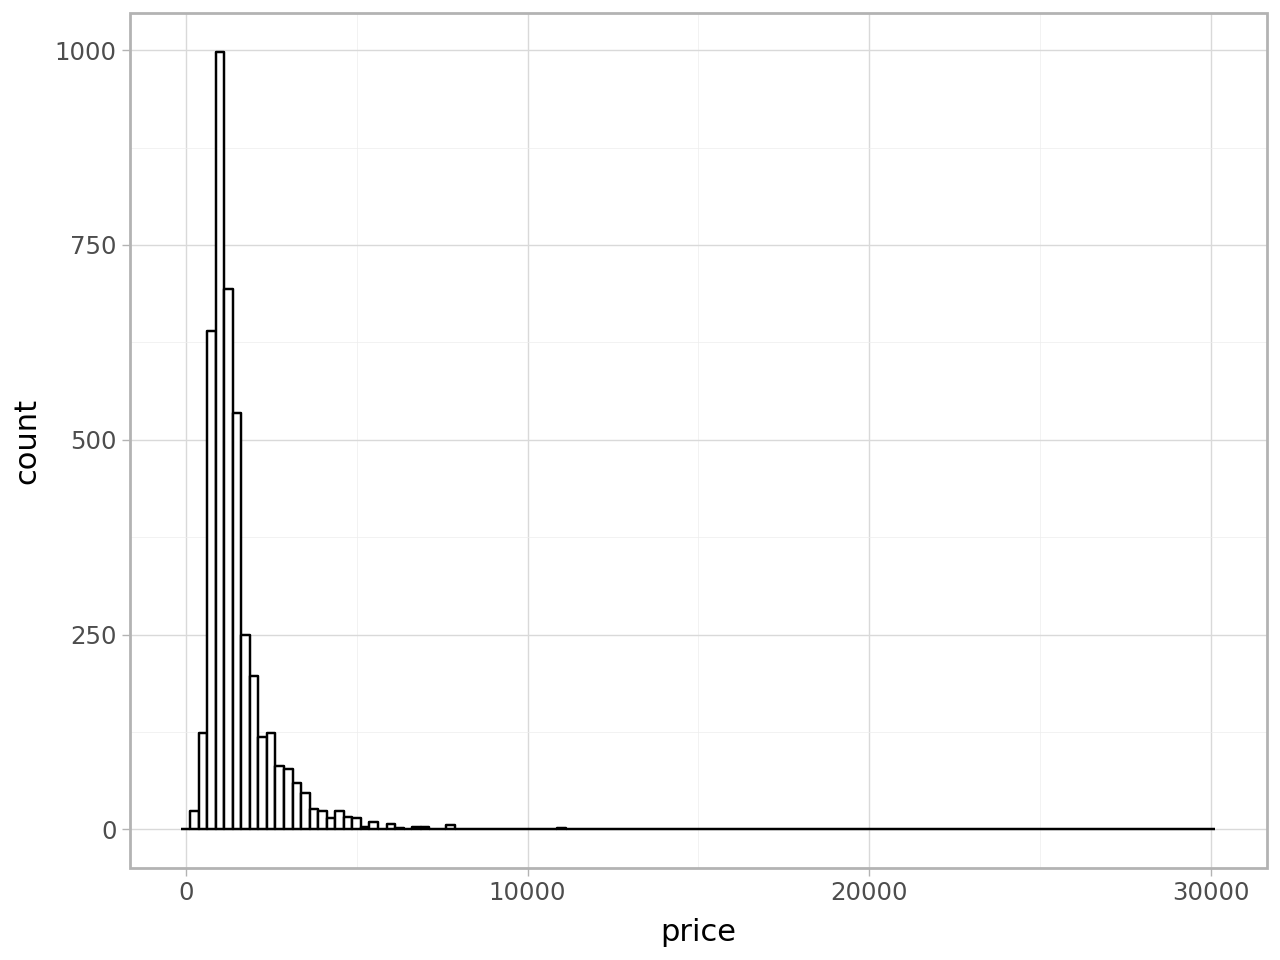

In [38]:
(
    ggplot(tiny_data)
    + aes(x = 'price')
    + geom_histogram(binwidth = 250, color = 'black', fill = 'white')
    + theme_light()
)

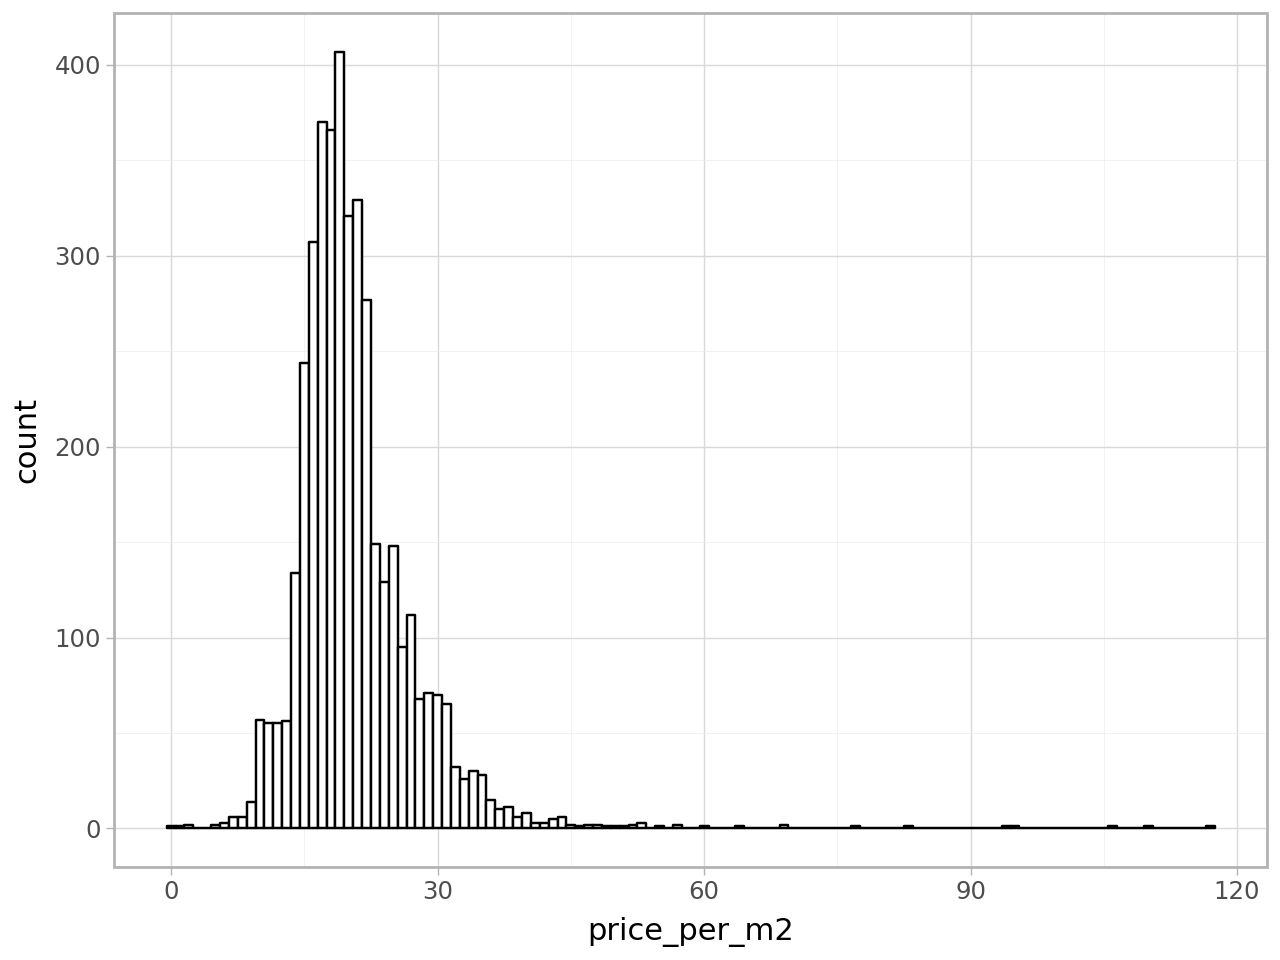

In [40]:
(
    ggplot(tiny_data)
    + aes(x = 'price_per_m2')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + theme_light()
)

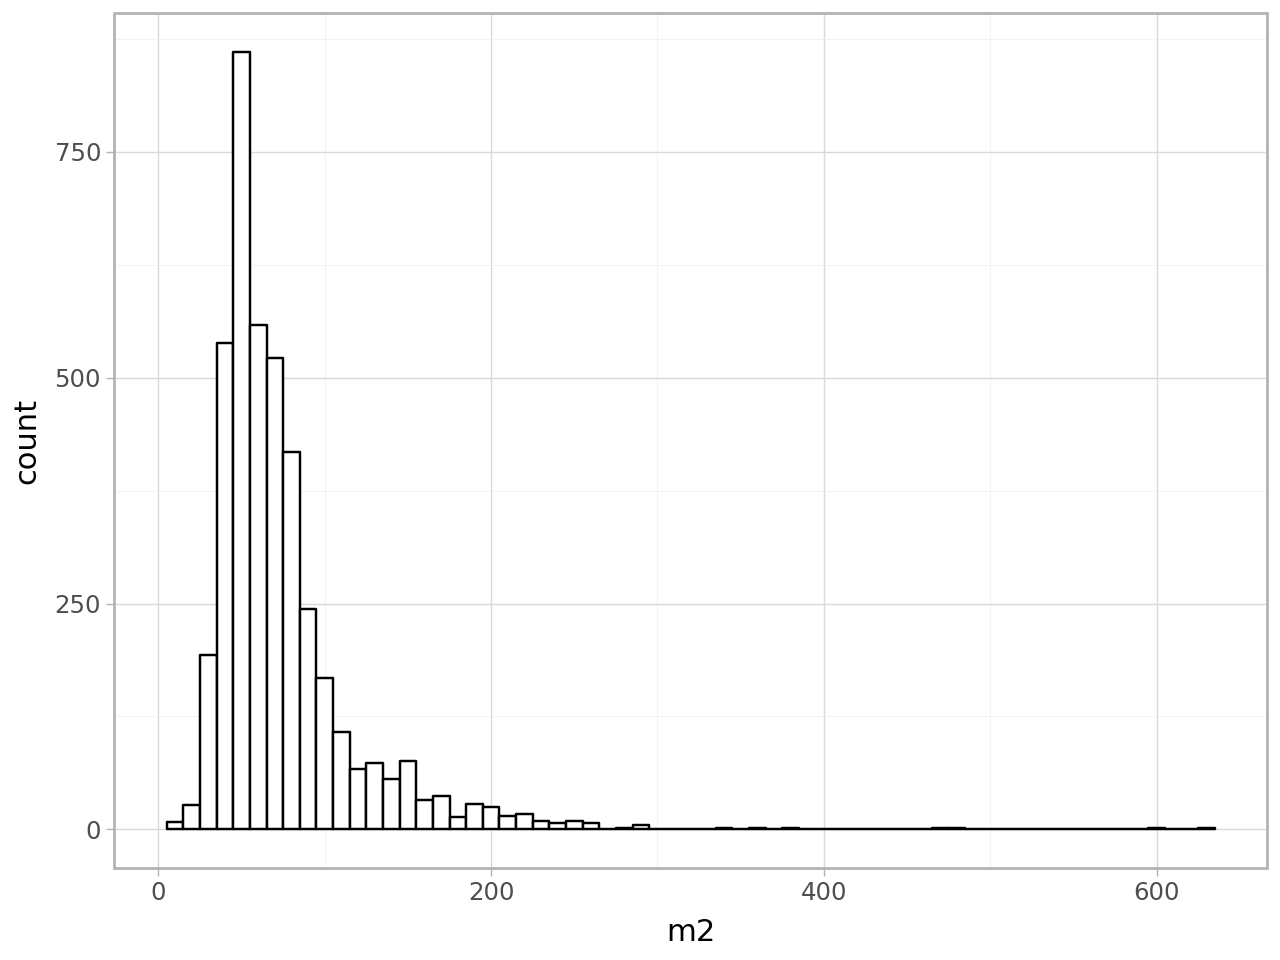

In [42]:
(
    ggplot(tiny_data)
    + aes(x = 'm2')
    + geom_histogram(binwidth = 10, color = 'black', fill = 'white')
    + theme_light()
)

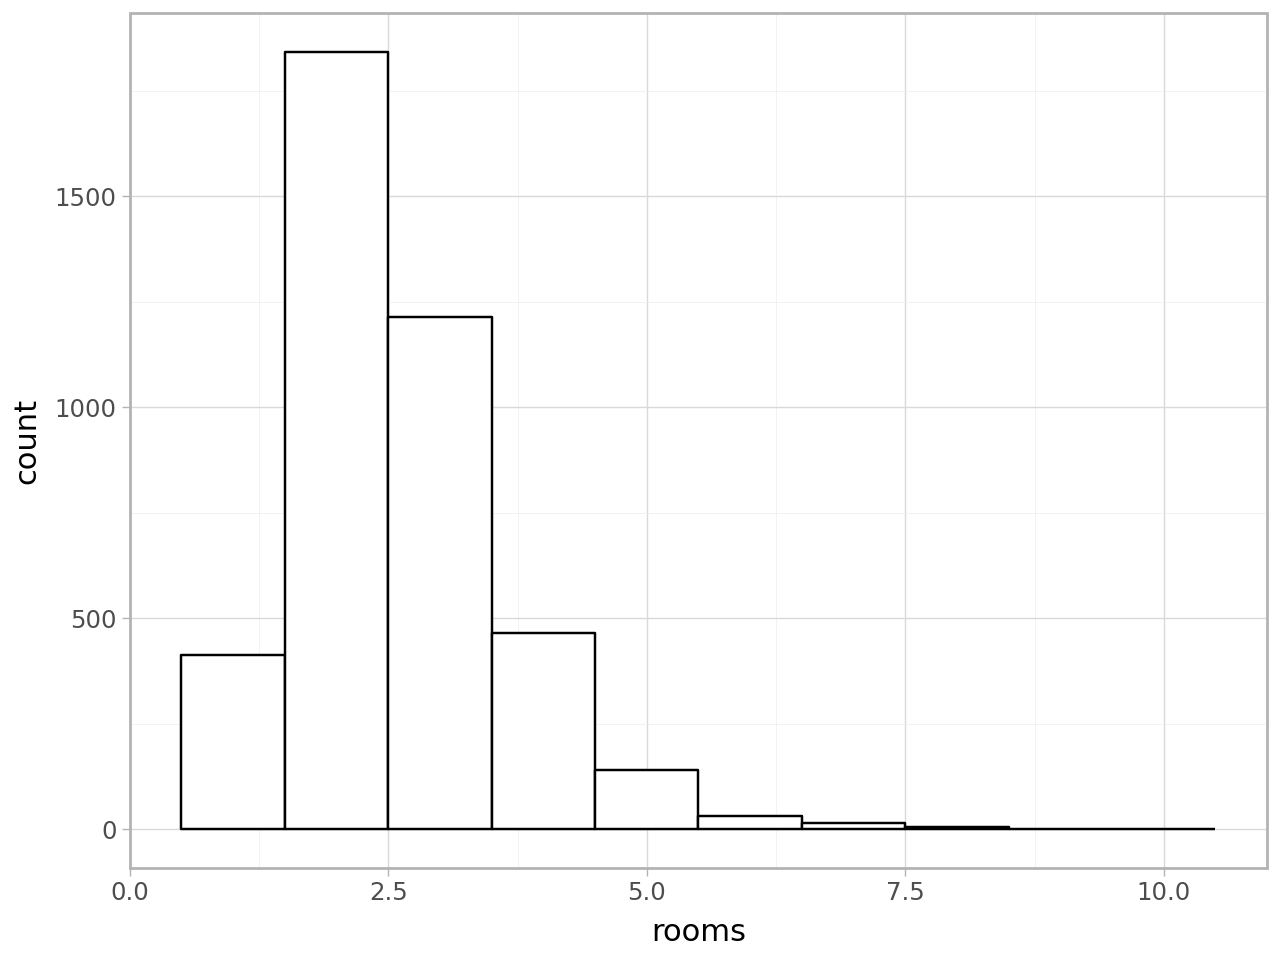

In [44]:
(
    ggplot(tiny_data)
    + aes(x = 'rooms')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + theme_light()
)

If we take the time, to brows through some listings on the original website, we can see that the extreme values in the distribution correspond to listings that are not quite interesting for us if we want to examine flats we might want to live in, as they are either too luxorious (maxima) or not meant for living, but are rather storage or garage places (minima). So, to ease further analysis, we shall drop observations that fall outside the 5-95 percentile ranges.

In [46]:
tiny_data = (
    tiny_data[(tiny_data['price'] >= np.quantile(tiny_data['price'],0.05)) 
    & (tiny_data['price'] <= np.quantile(tiny_data['price'],0.95))
    & (tiny_data['price_per_m2'] >= np.quantile(tiny_data['price_per_m2'],0.05)) 
    & (tiny_data['price_per_m2'] <= np.quantile(tiny_data['price_per_m2'],0.95))
    & (tiny_data['m2'] >= np.quantile(tiny_data['m2'],0.05)) 
    & (tiny_data['m2'] <= np.quantile(tiny_data['m2'],0.95))
    & (tiny_data['rooms'] >= np.quantile(tiny_data['rooms'],0.05)) 
    & (tiny_data['rooms'] <= np.quantile(tiny_data['rooms'],0.95))]
)

The summary stats now seem okay, but let's plot again!

In [48]:
tiny_data.describe().T

count         mean         std         min         25%  \
price         3275.0  1359.569490  546.639097  689.580000  950.000000   
price_per_m2  3275.0    19.987790    4.072091   12.697286   16.980497   
m2            3275.0    68.713282   24.879795   35.000000   50.000000   
rooms         3275.0     2.506260    0.754668    1.000000    2.000000   

                      50%          75%          max  
price         1215.360000  1562.610000  3422.350000  
price_per_m2    19.280702    22.018761    31.666667  
m2              63.000000    80.500000   158.000000  
rooms            2.000000     3.000000     4.000000

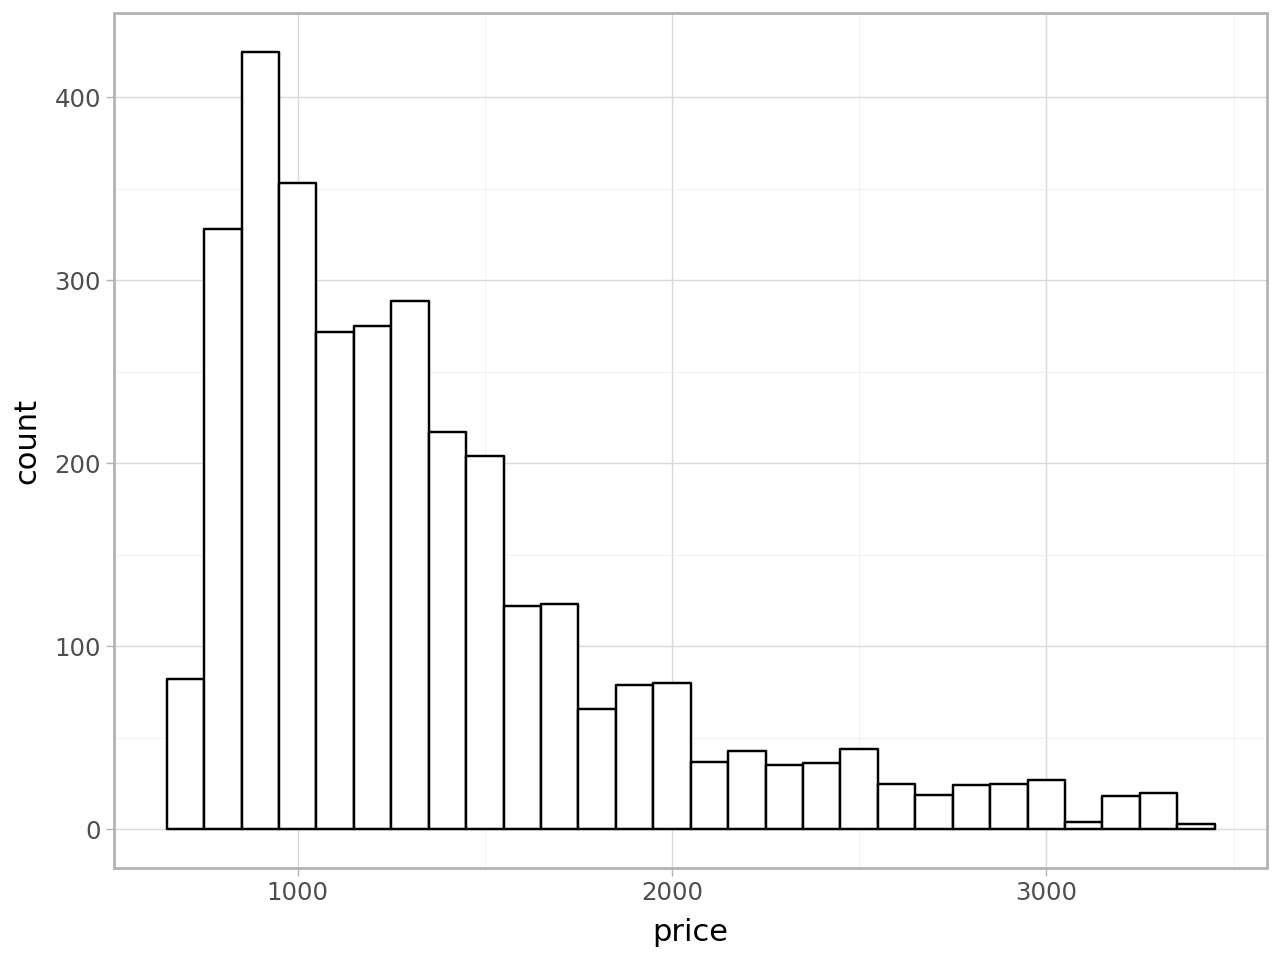

In [50]:
(
    ggplot(tiny_data)
    + aes(x = 'price')
    + geom_histogram(binwidth = 100, color = 'black', fill = 'white')
    + theme_light()
)

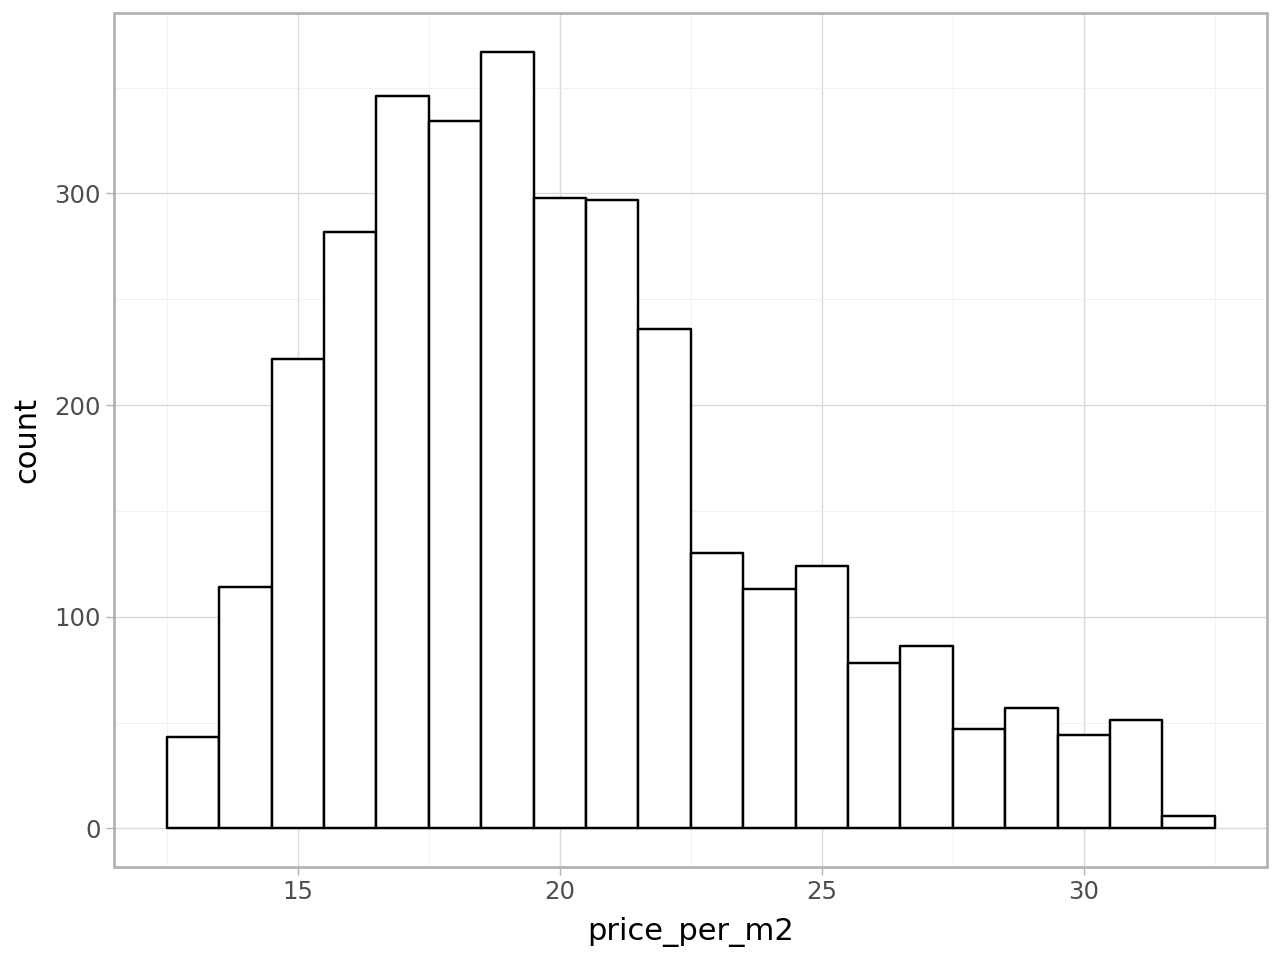

In [52]:
(
    ggplot(tiny_data)
    + aes(x = 'price_per_m2')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + theme_light()
)

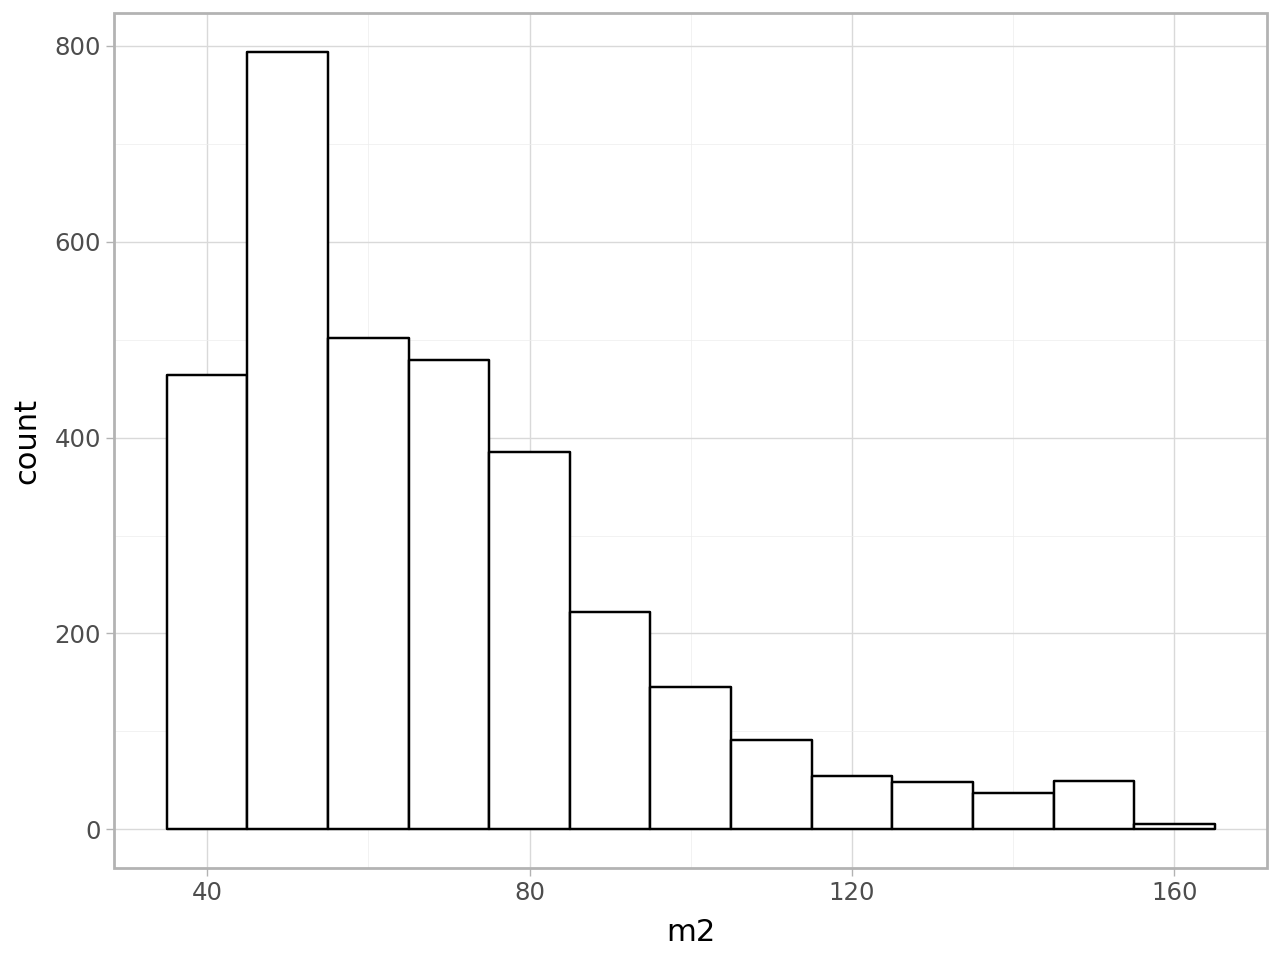

In [54]:
(
    ggplot(tiny_data)
    + aes(x = 'm2')
    + geom_histogram(binwidth = 10, color = 'black', fill = 'white')
    + theme_light()
)

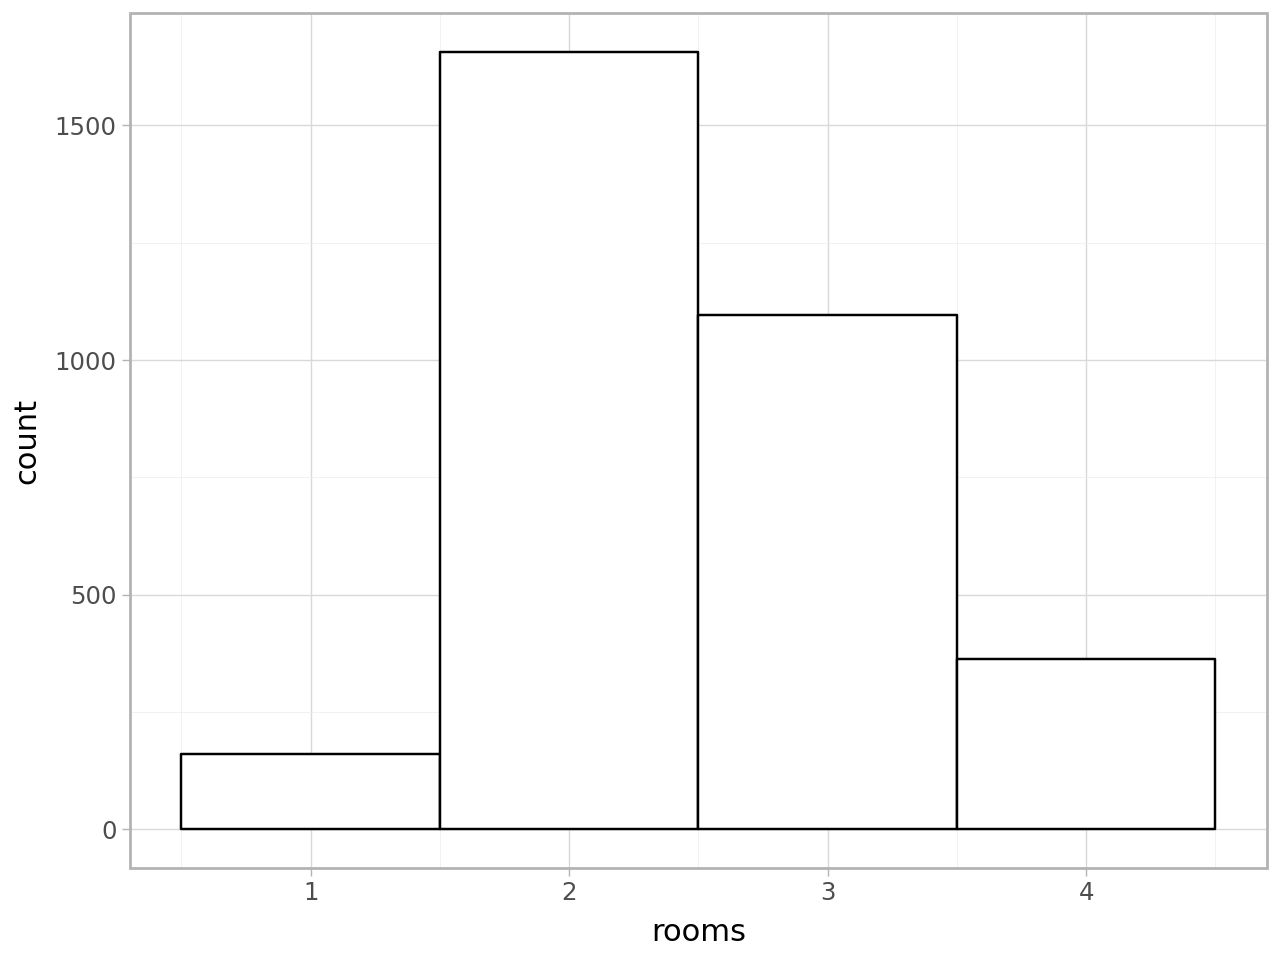

In [56]:
(
    ggplot(tiny_data)
    + aes(x = 'rooms')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + theme_light()
)

With this cleaned data, we can now plot some interesting graphs.

First, let's look at price distributions in each bezirk.

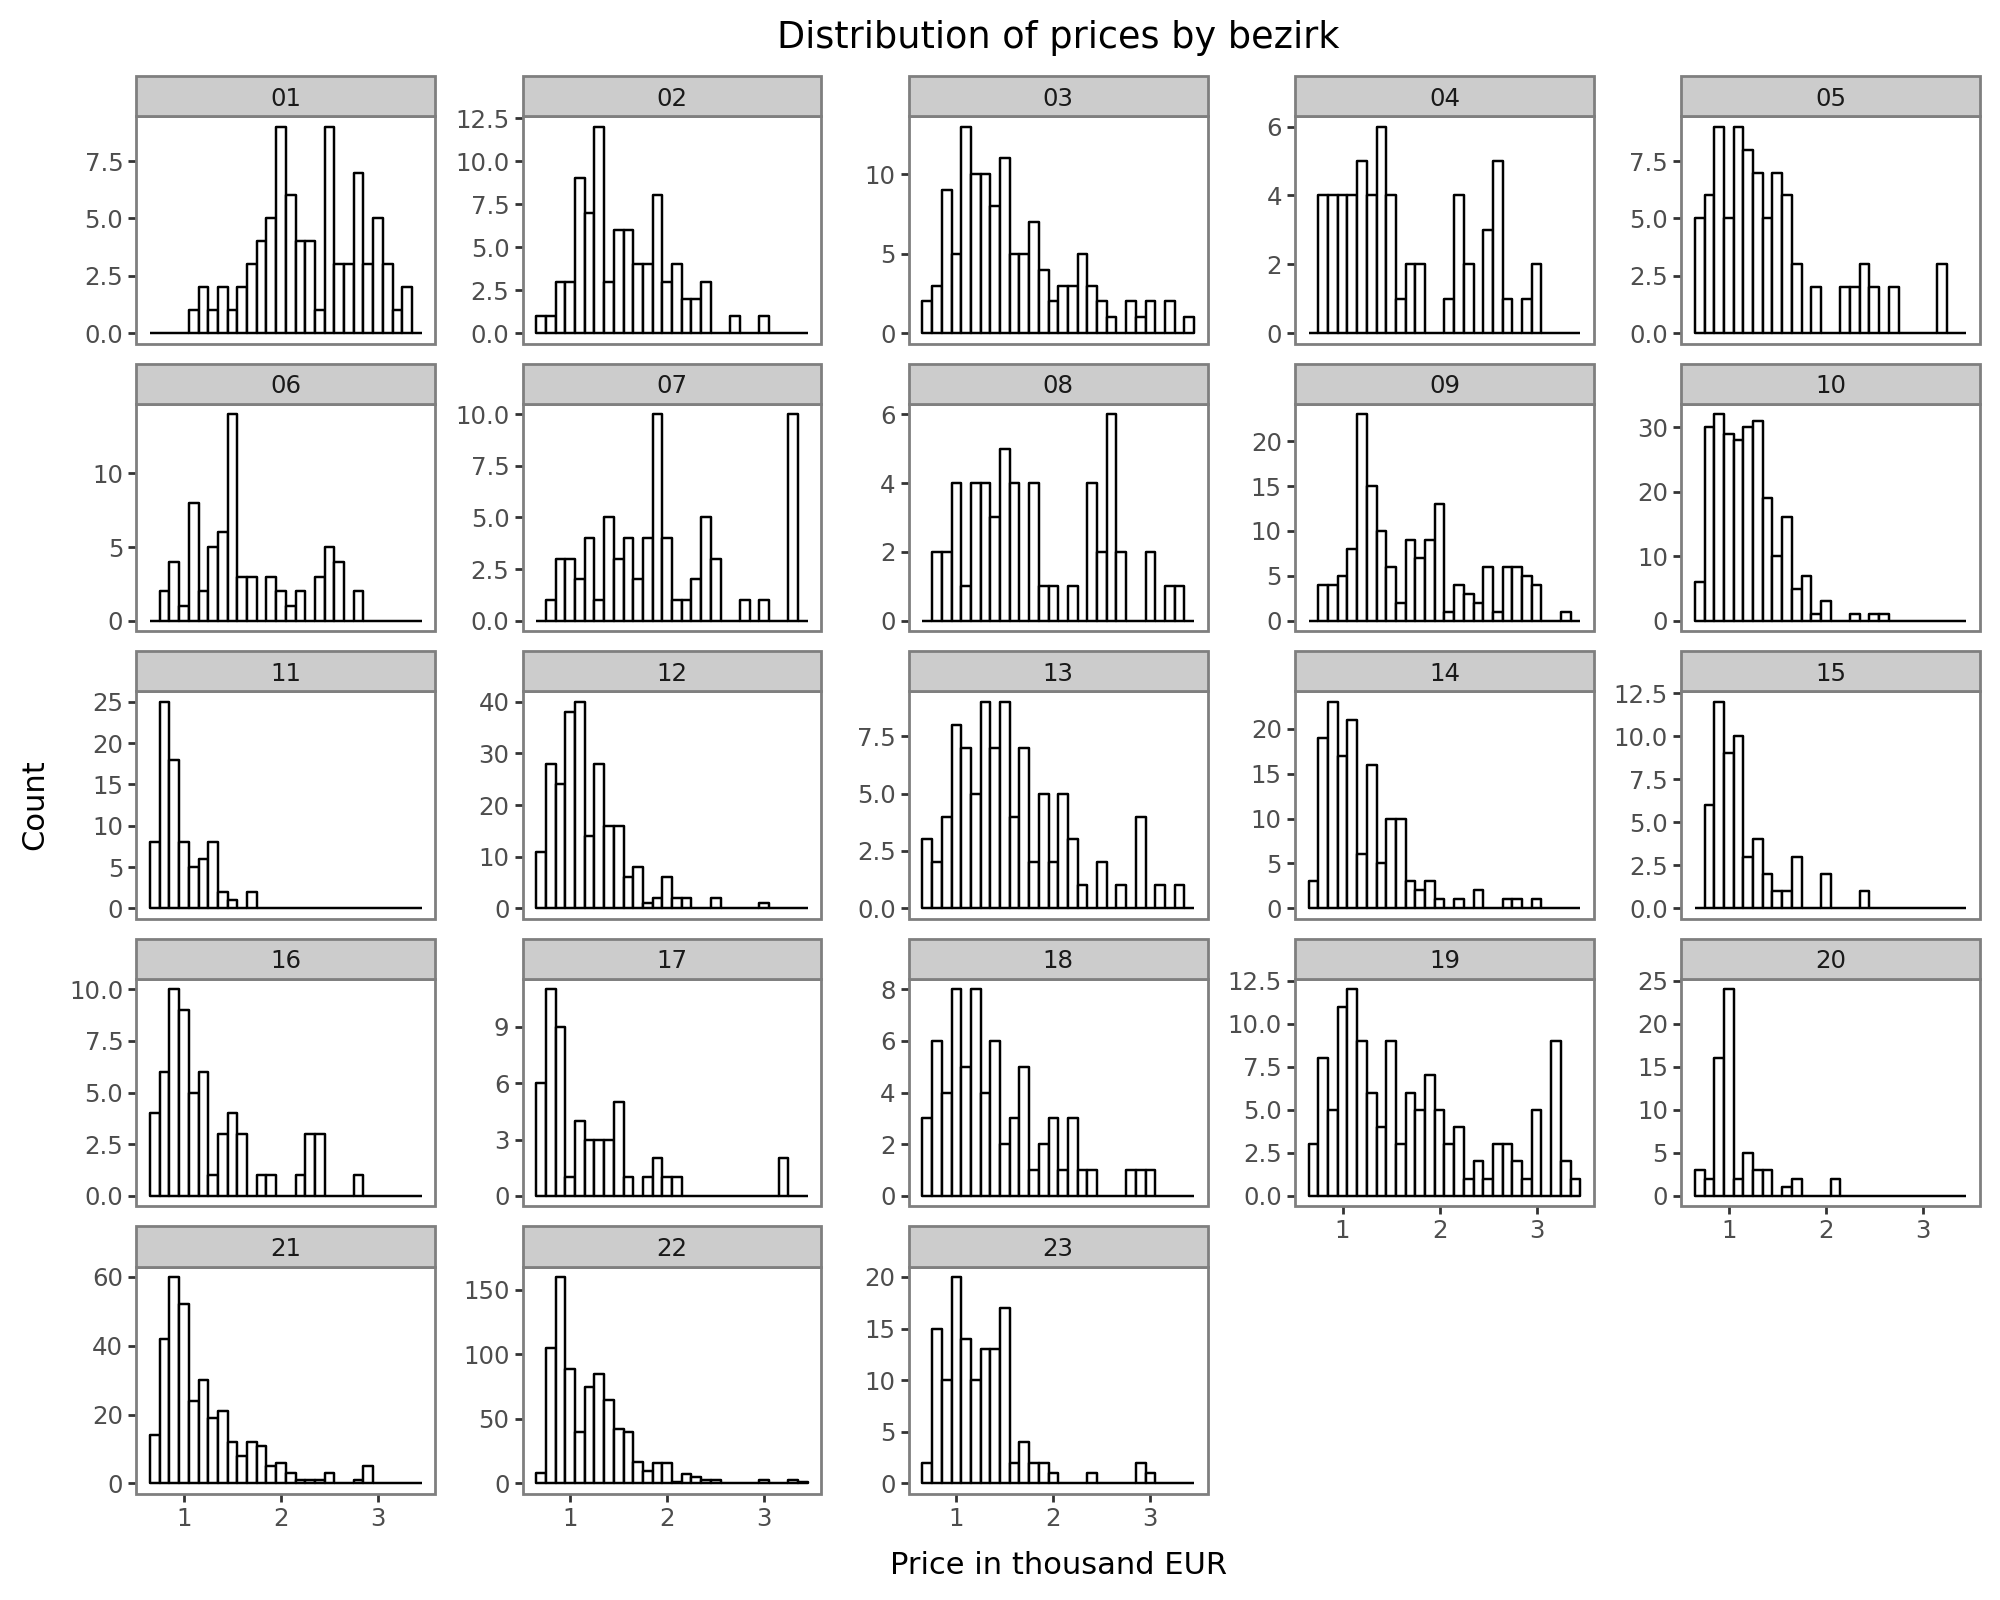

In [58]:
(
    ggplot(tiny_data)
    + aes(x = 'price / 1000')
    + geom_histogram(binwidth = 0.1, color = 'black', fill = 'white')
    + facet_wrap('bezirk', scales="free_y")
    + theme_bw()
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), figure_size=(10, 8))
    + labs(x = 'Price in thousand EUR', y = 'Count', title = 'Distribution of prices by bezirk')
)

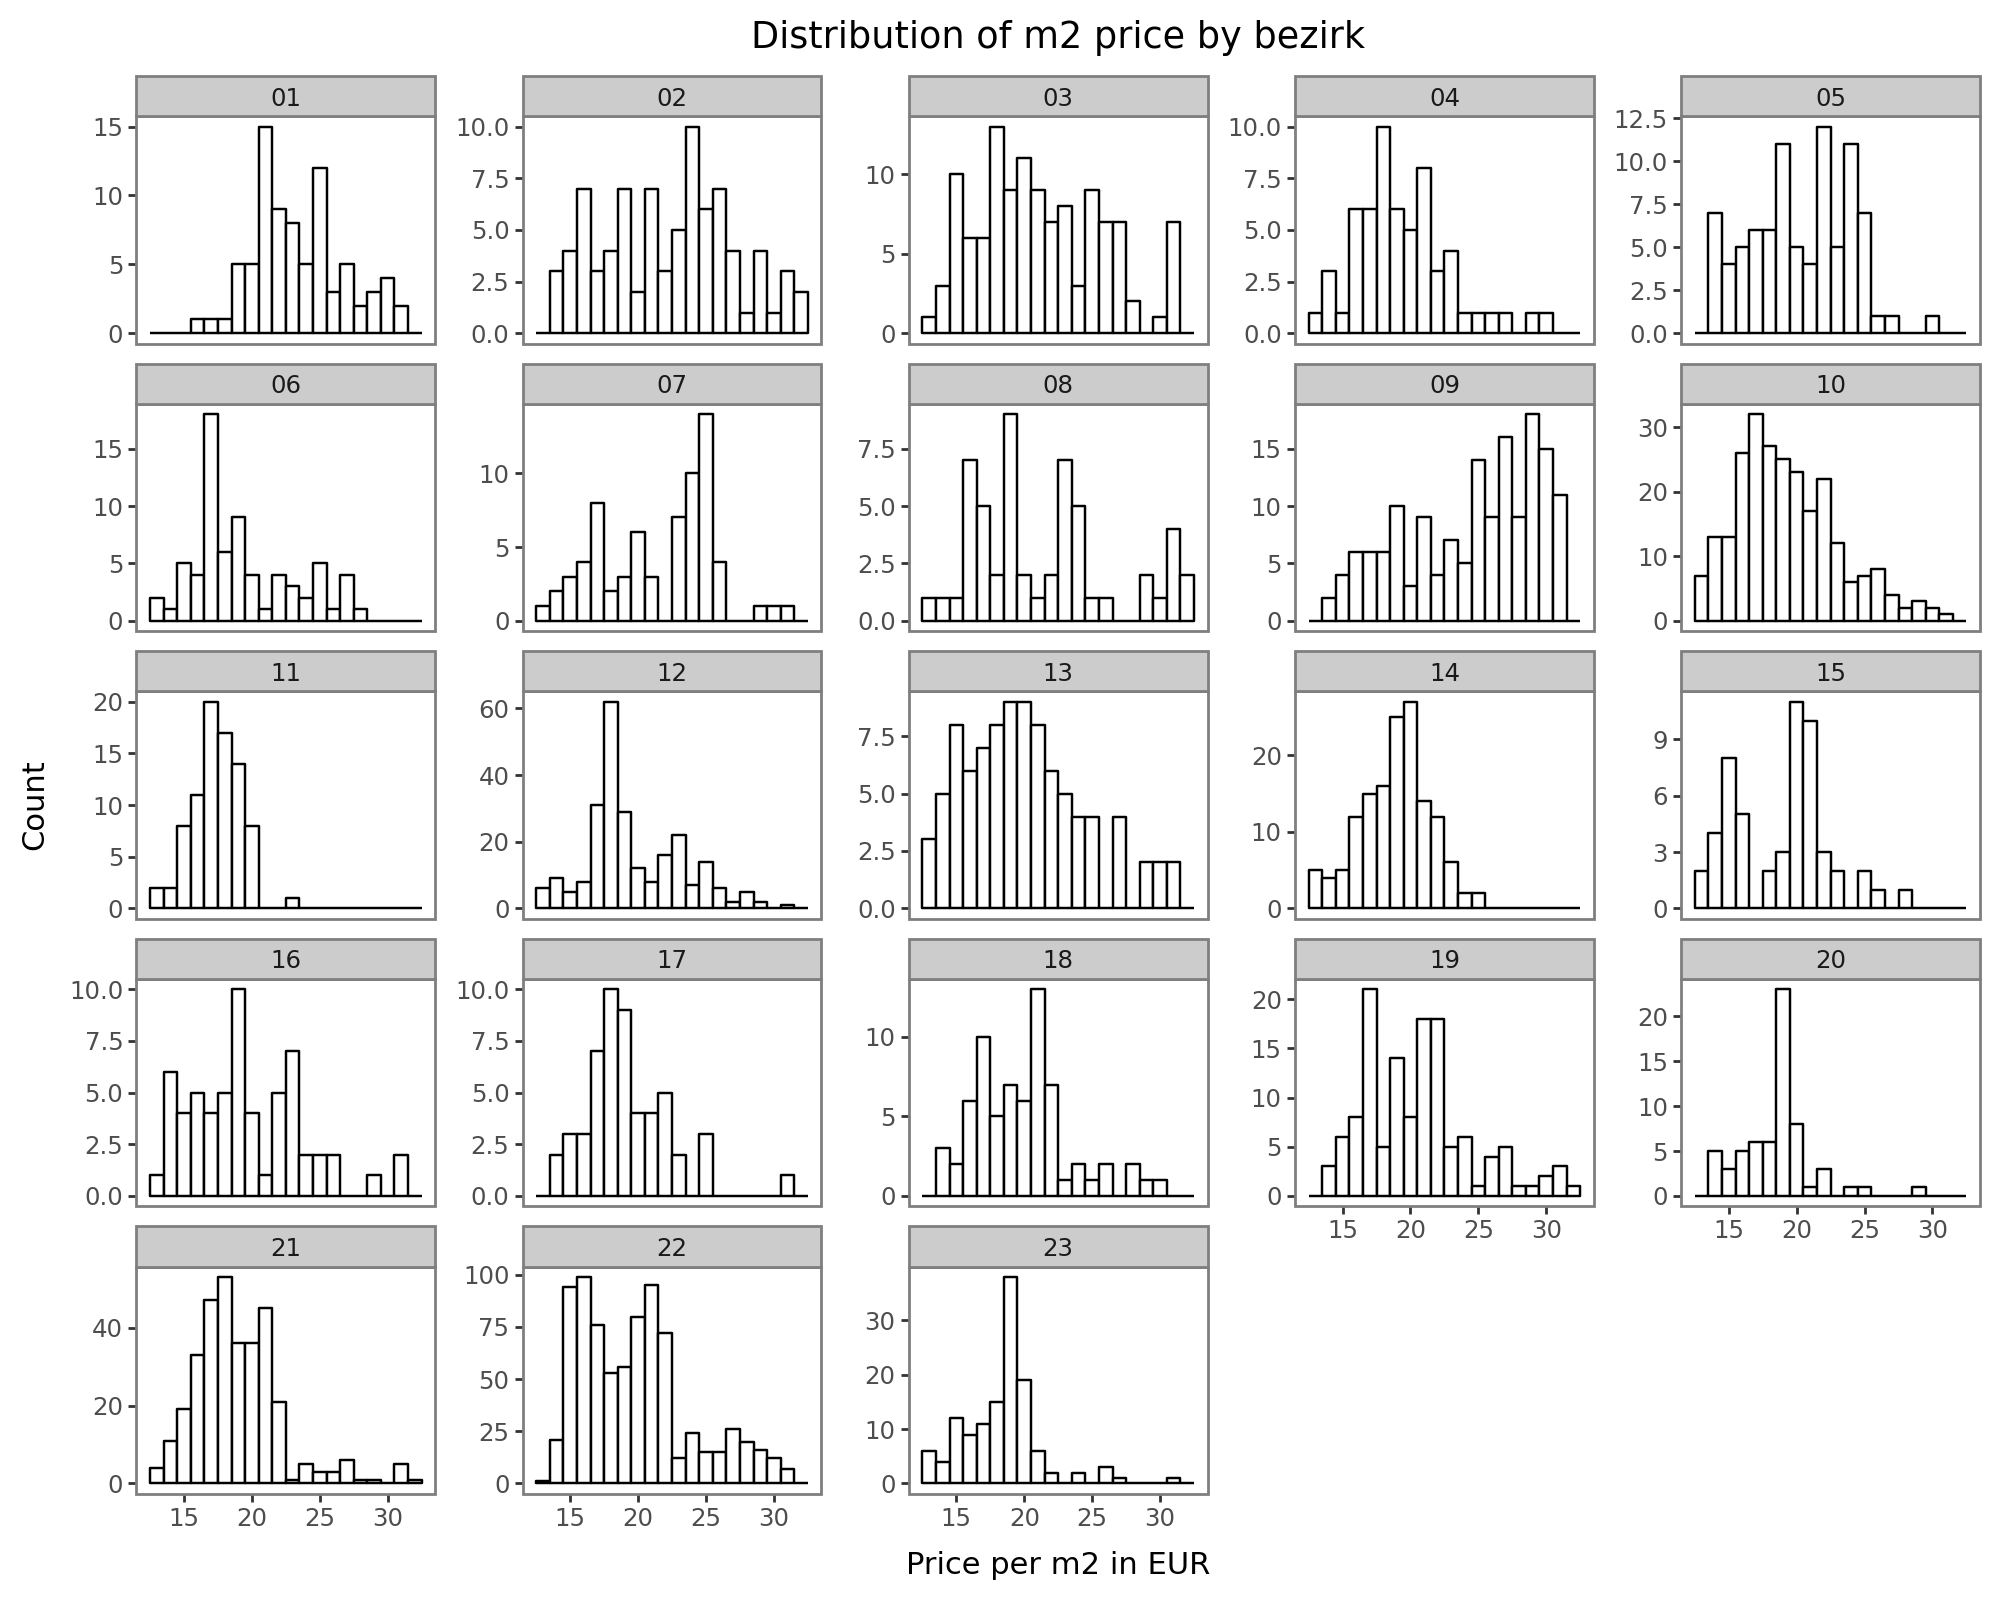

In [60]:
(
    ggplot(tiny_data)
    + aes(x = 'price_per_m2')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + facet_wrap('bezirk', scales="free_y")
    + theme_bw()
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), figure_size=(10, 8))
    + labs(x = 'Price per m2 in EUR', y = 'Count', title = 'Distribution of m2 price by bezirk')
)

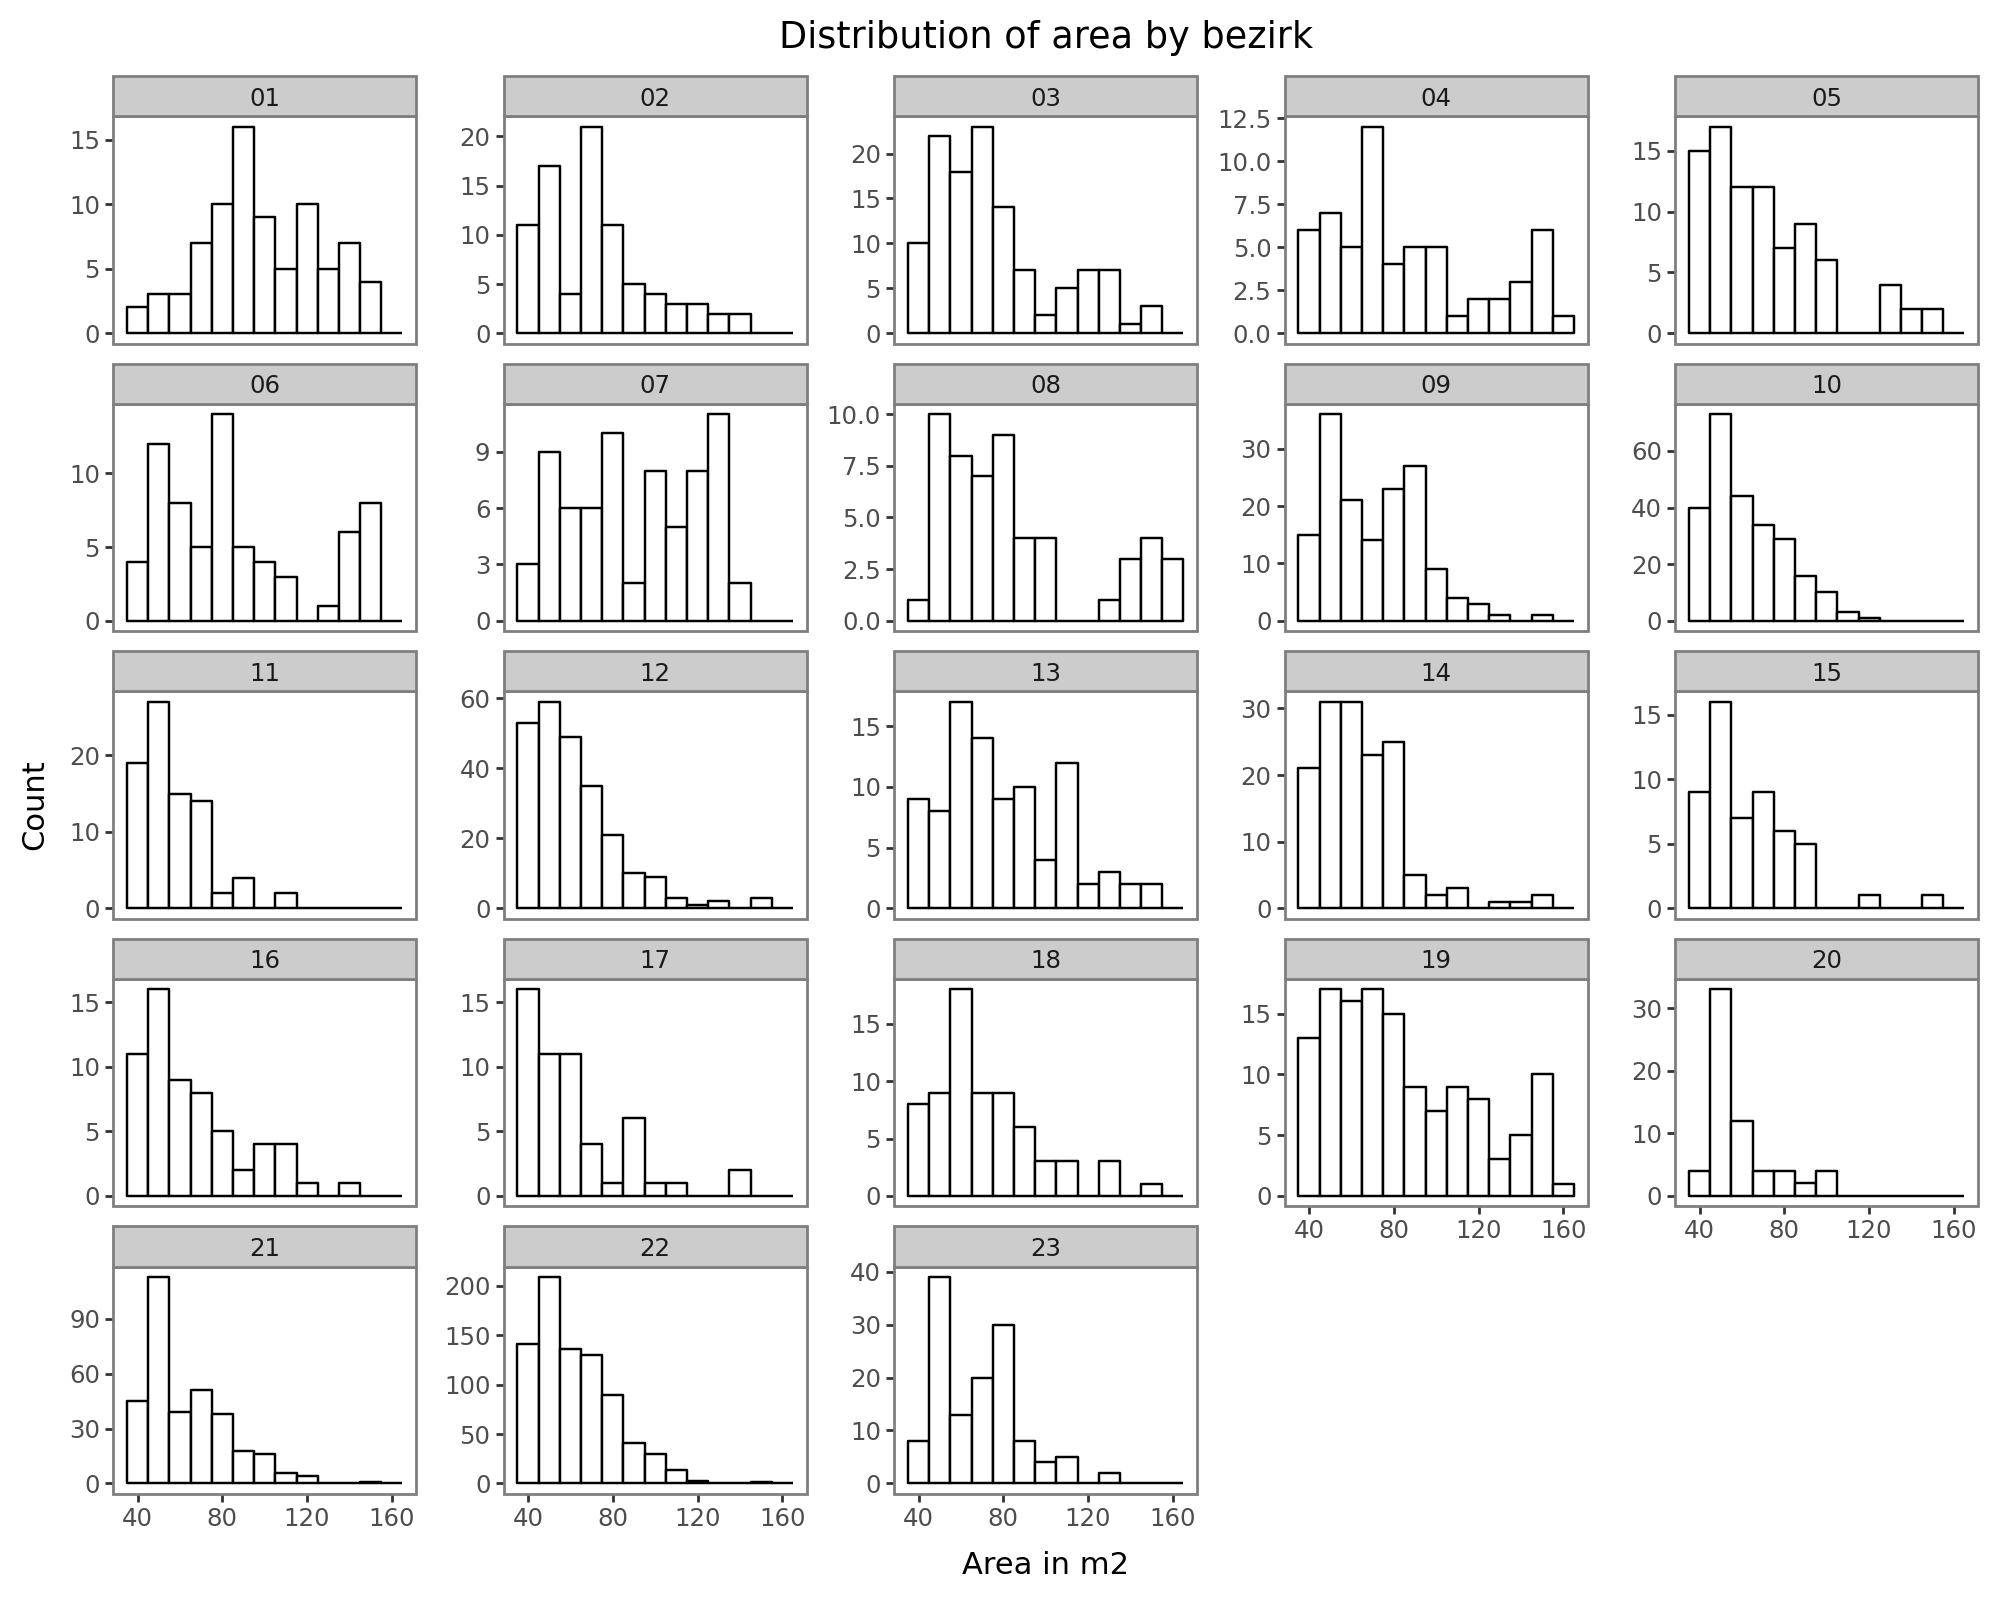

In [62]:
(
    ggplot(tiny_data)
    + aes(x = 'm2')
    + geom_histogram(binwidth = 10, color = 'black', fill = 'white')
    + facet_wrap('bezirk', scales="free_y")
    + theme_bw()
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), figure_size=(10, 8))
    + labs(x = 'Area in m2', y = 'Count', title = 'Distribution of area by bezirk')
)

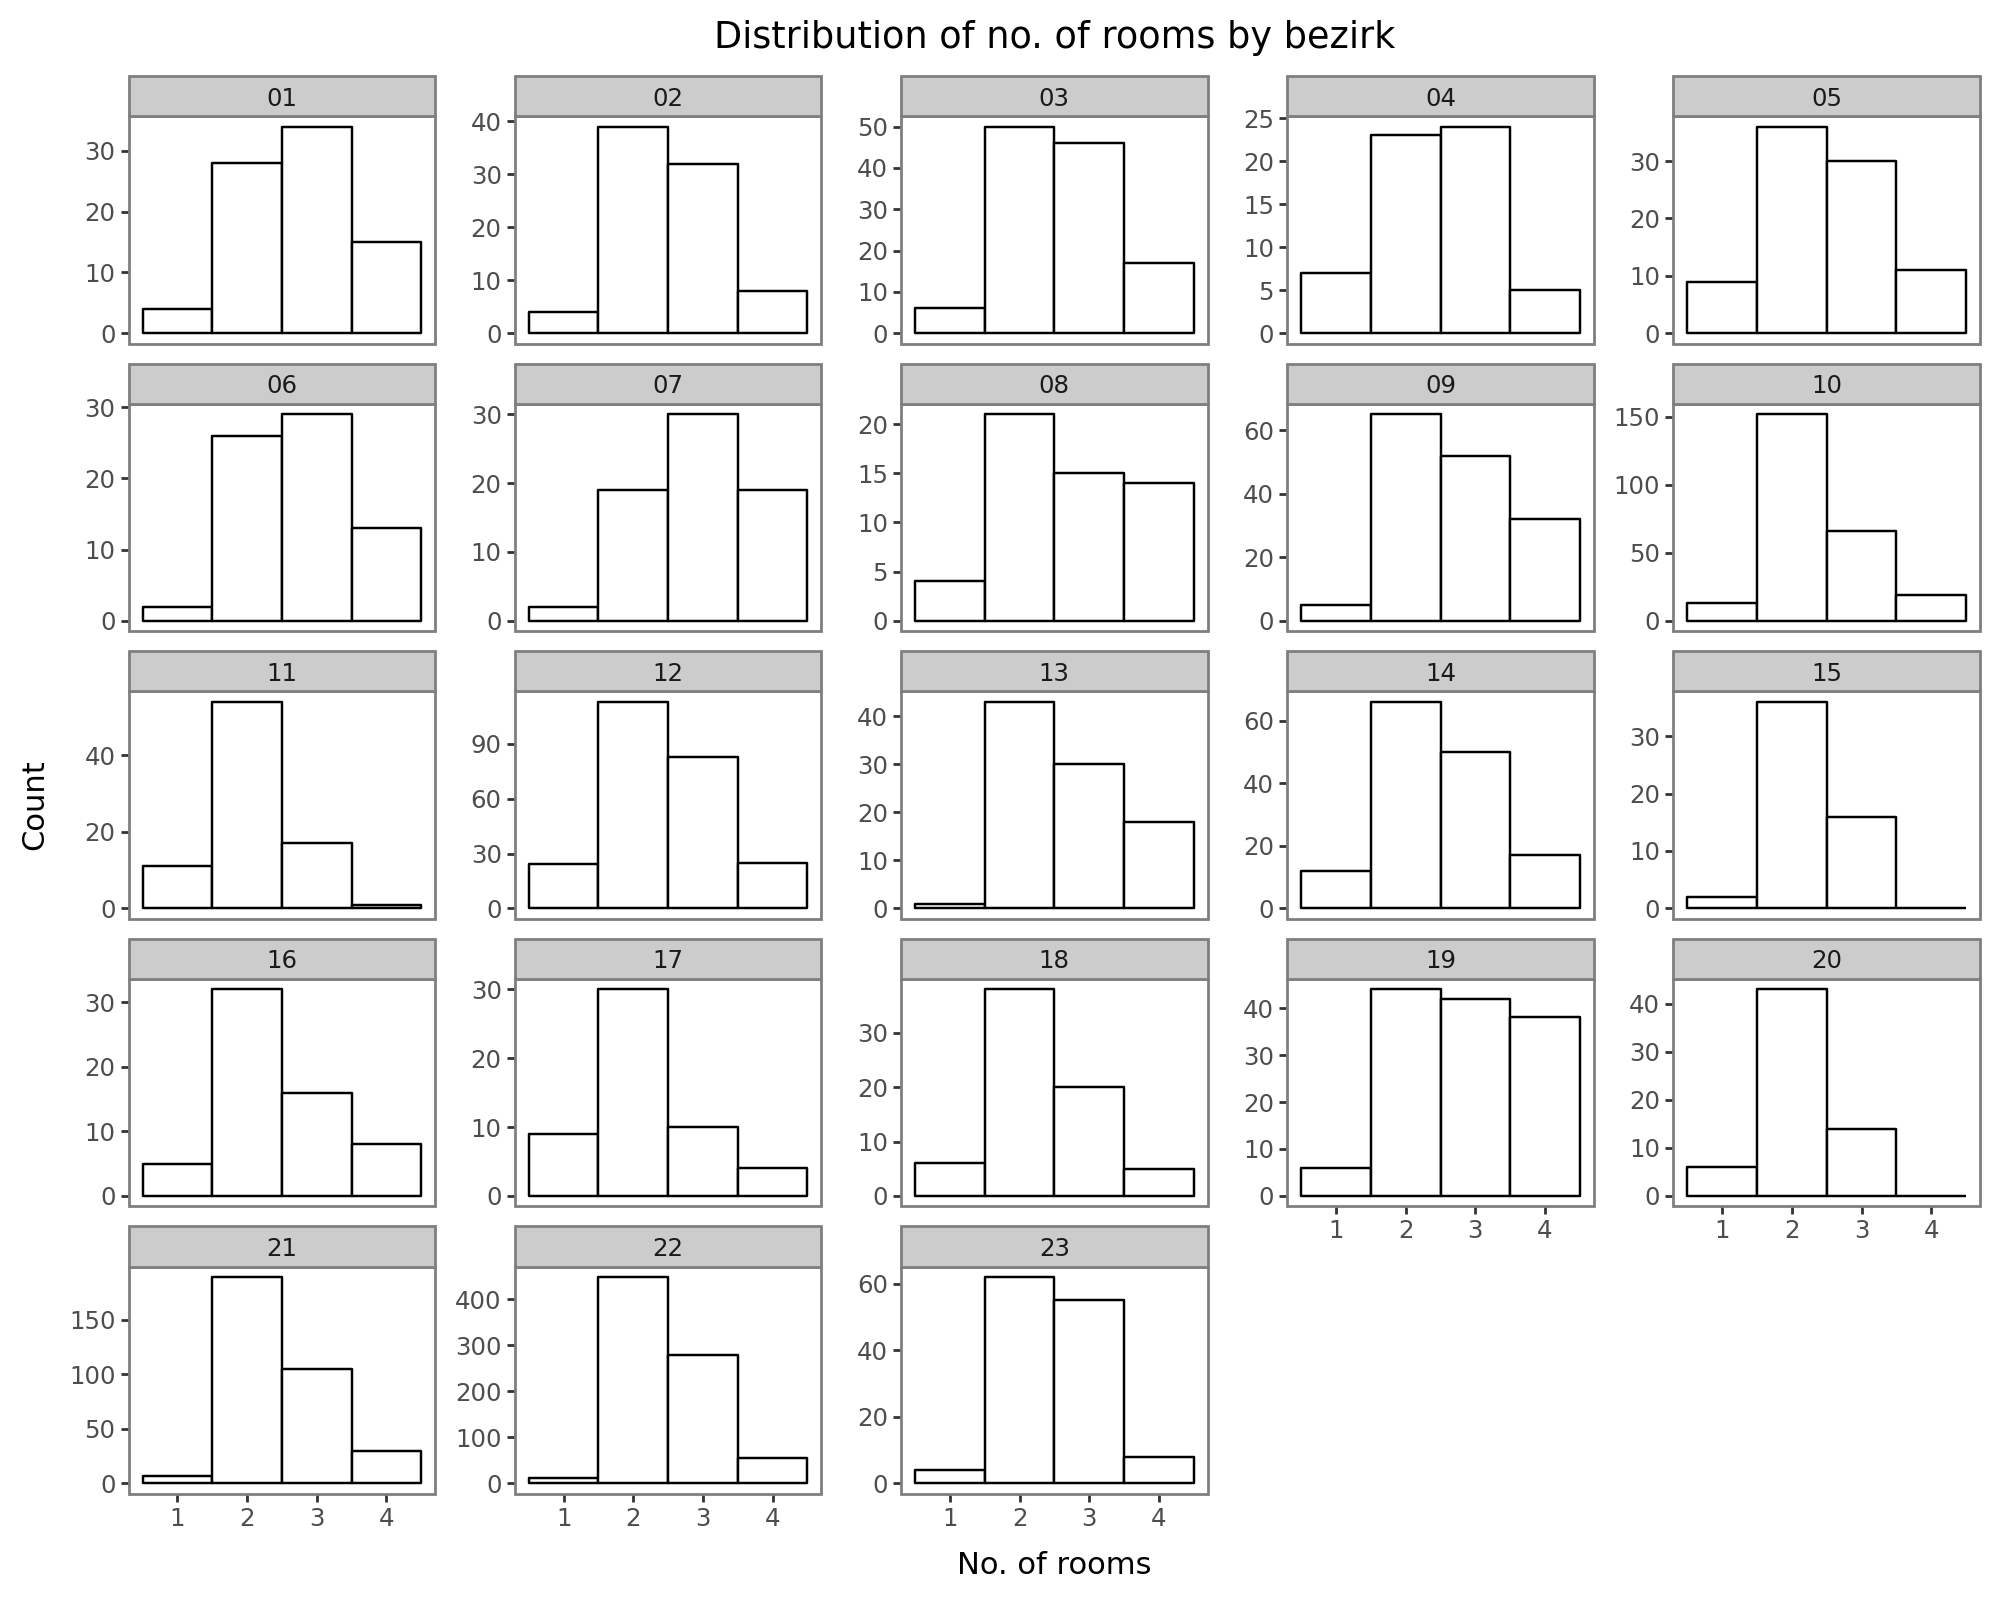

In [63]:
(
    ggplot(tiny_data)
    + aes(x = 'rooms')
    + geom_histogram(binwidth = 1, color = 'black', fill = 'white')
    + facet_wrap('bezirk', scales="free_y")
    + theme_bw()
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank(), figure_size=(10, 8))
    + labs(x = 'No. of rooms', y = 'Count', title = 'Distribution of no. of rooms by bezirk')
)

To ease comparison, let's do some boxplots conditional on bezirk as well (excluding no. of rooms, as with such small range, it would be meaningless)!

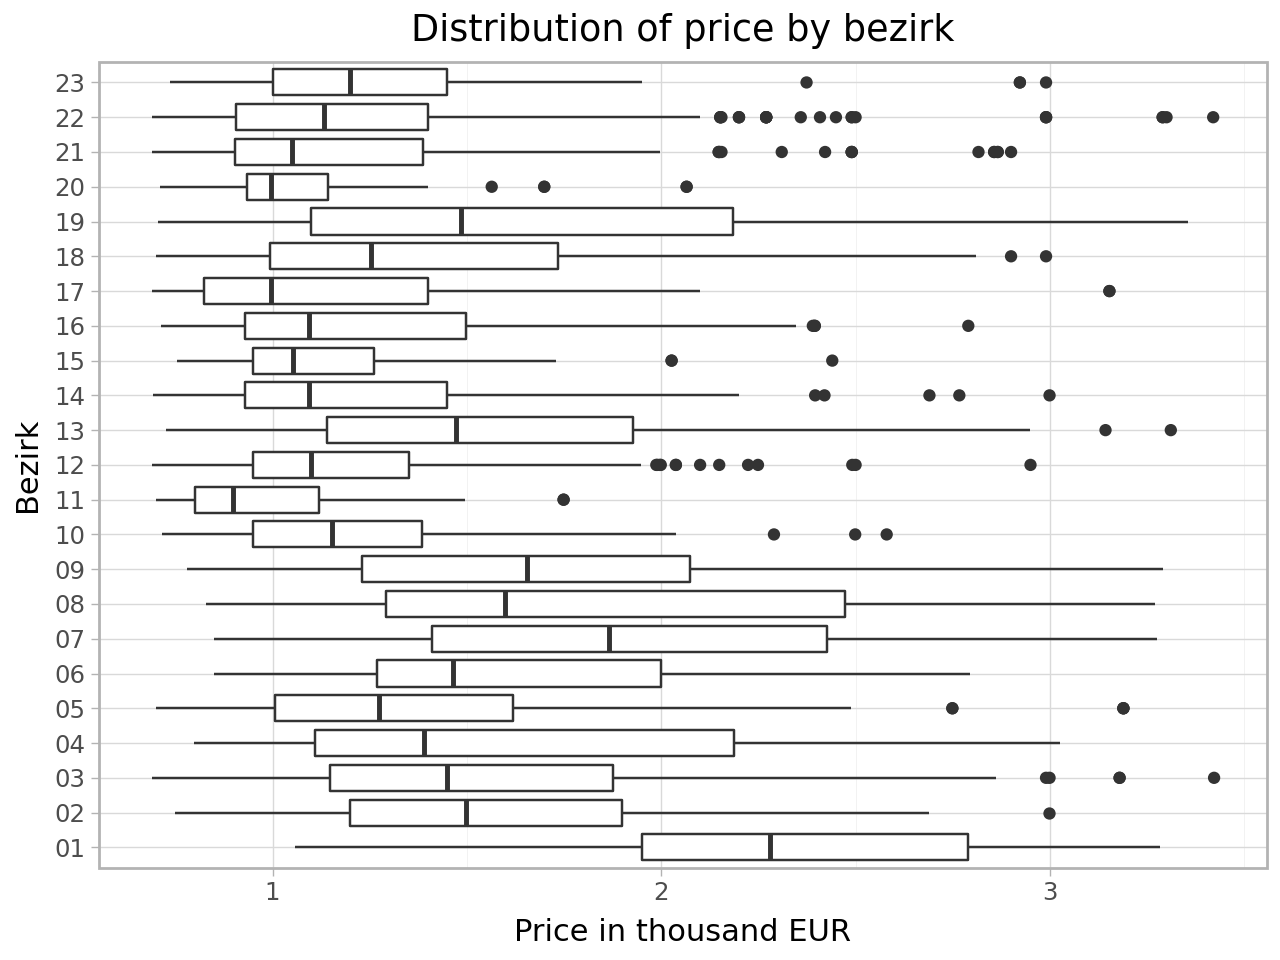

In [66]:
(
    ggplot(tiny_data)
    + aes(x ='bezirk', y = 'price / 1000')
    + geom_boxplot()
    + coord_flip()
    + labs(x = 'Bezirk', y = 'Price in thousand EUR', title = 'Distribution of price by bezirk')
    + theme_light()
)

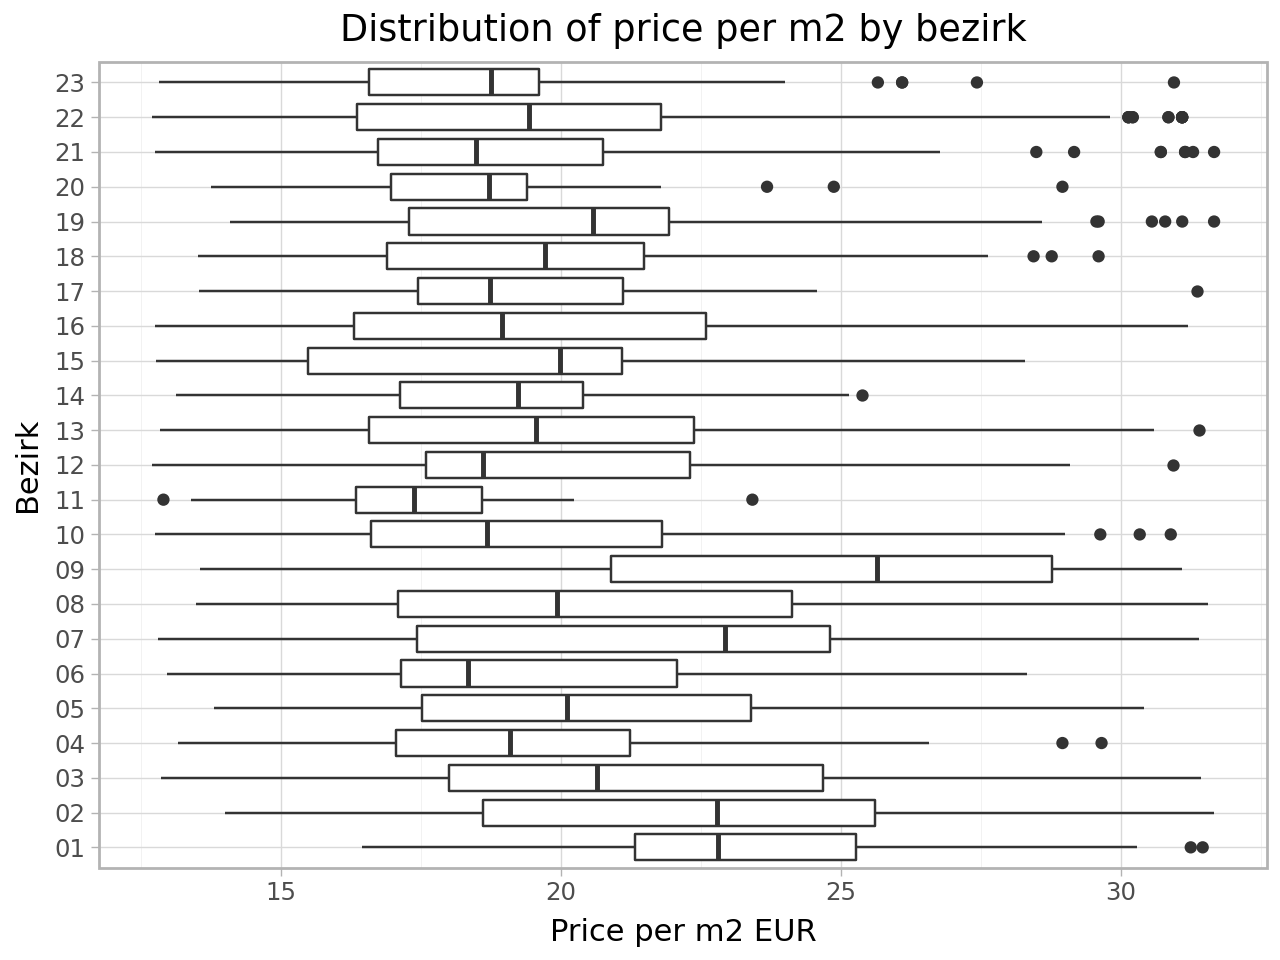

In [68]:
(
    ggplot(tiny_data)
    + aes(x ='bezirk', y = 'price_per_m2')
    + geom_boxplot()
    + coord_flip()
    + labs(x = 'Bezirk', y = 'Price per m2 EUR', title = 'Distribution of price per m2 by bezirk')
    + theme_light()
)

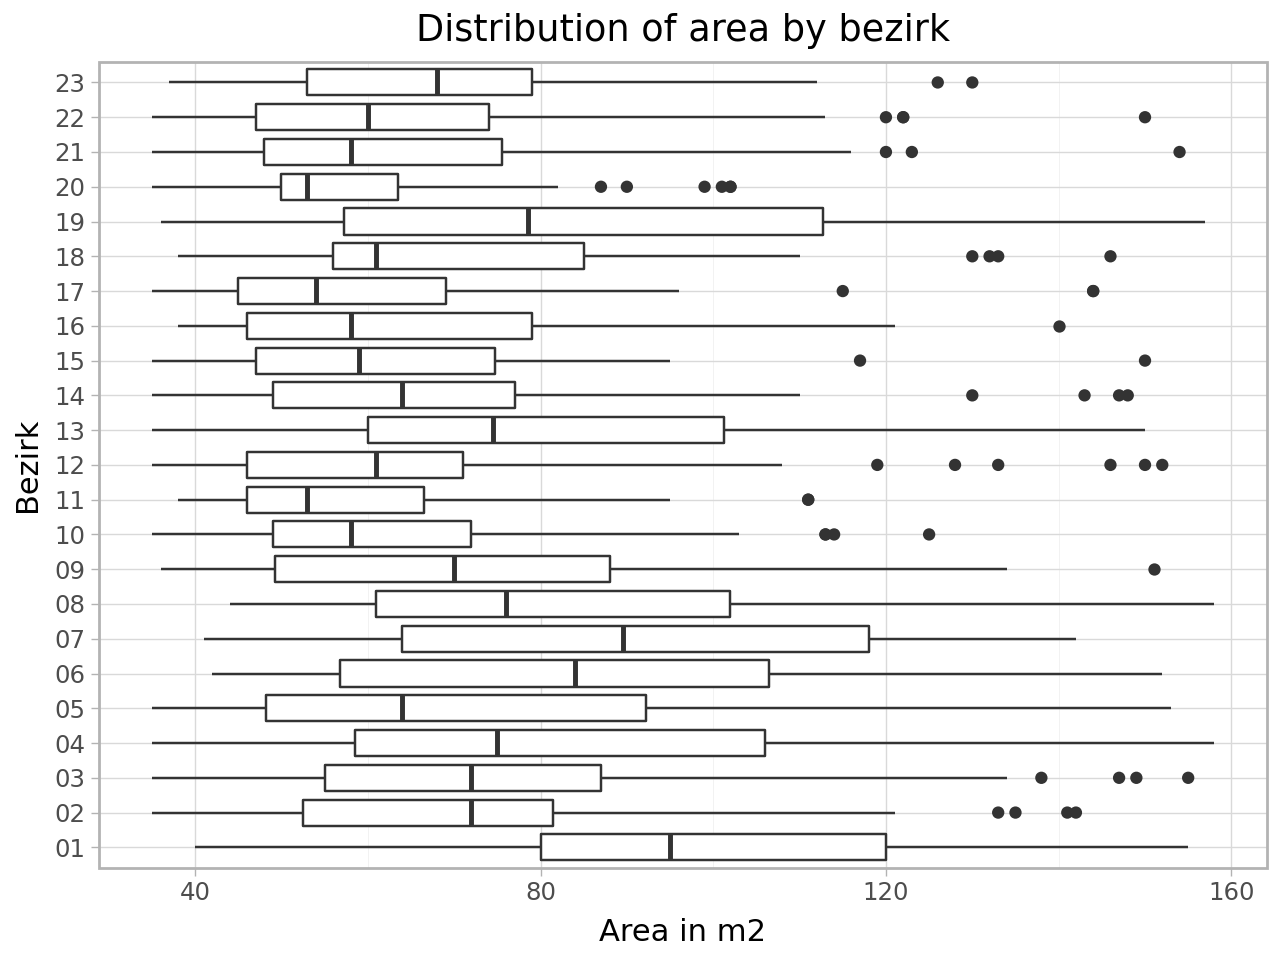

In [70]:
(
    ggplot(tiny_data)
    + aes(x ='bezirk', y = 'm2')
    + geom_boxplot()
    + coord_flip()
    + labs(x = 'Bezirk', y = 'Area in m2', title = 'Distribution of area by bezirk')
    + theme_light()
)

Now let's compare listings by private individuals versus listings by firms!

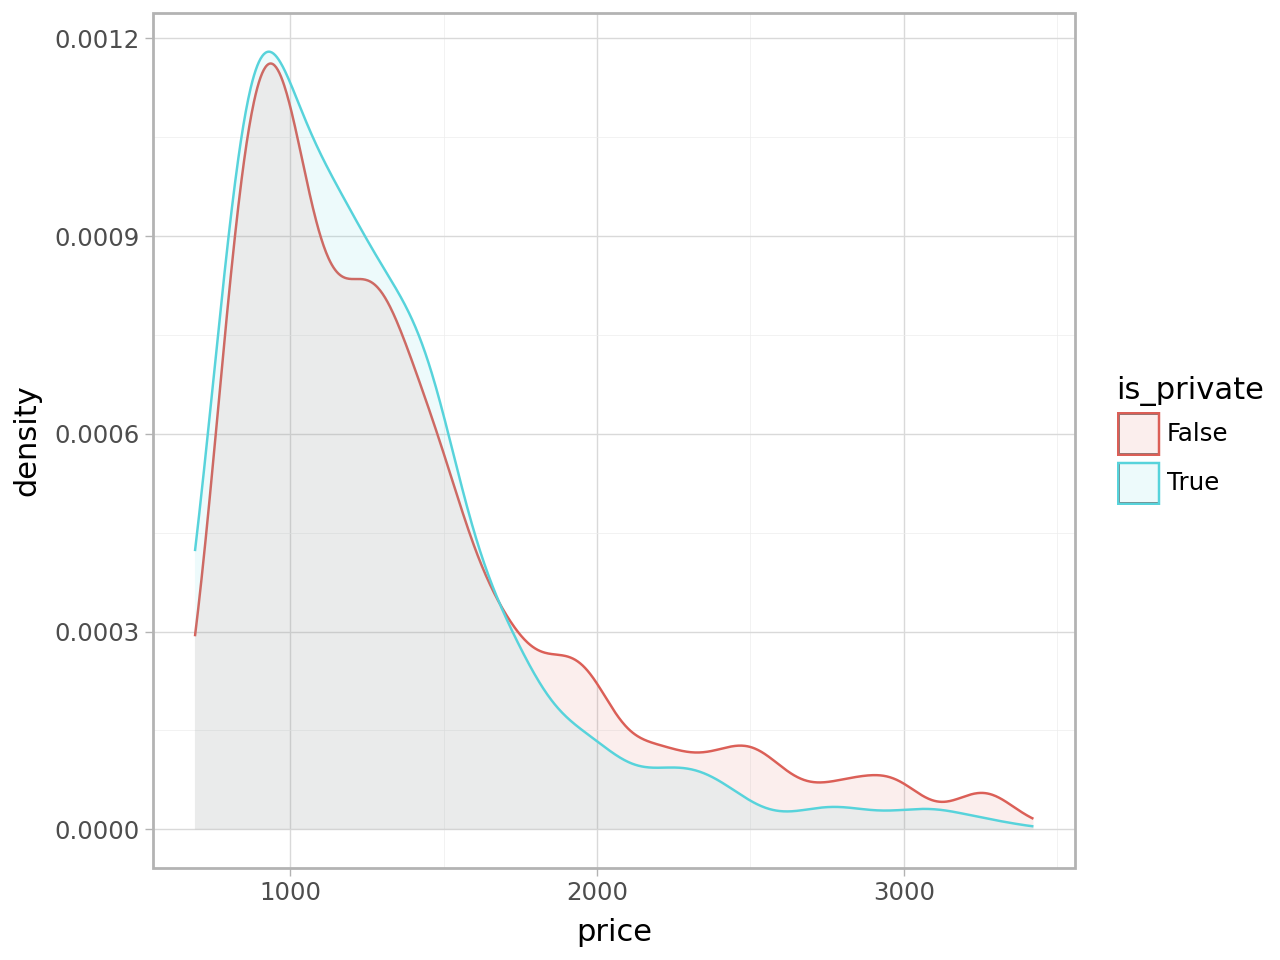

In [72]:
(
    ggplot(tiny_data)
    + aes(x = 'price', color = 'is_private', fill = 'is_private')
    + geom_density(alpha = 0.1)
    + theme_light()
)

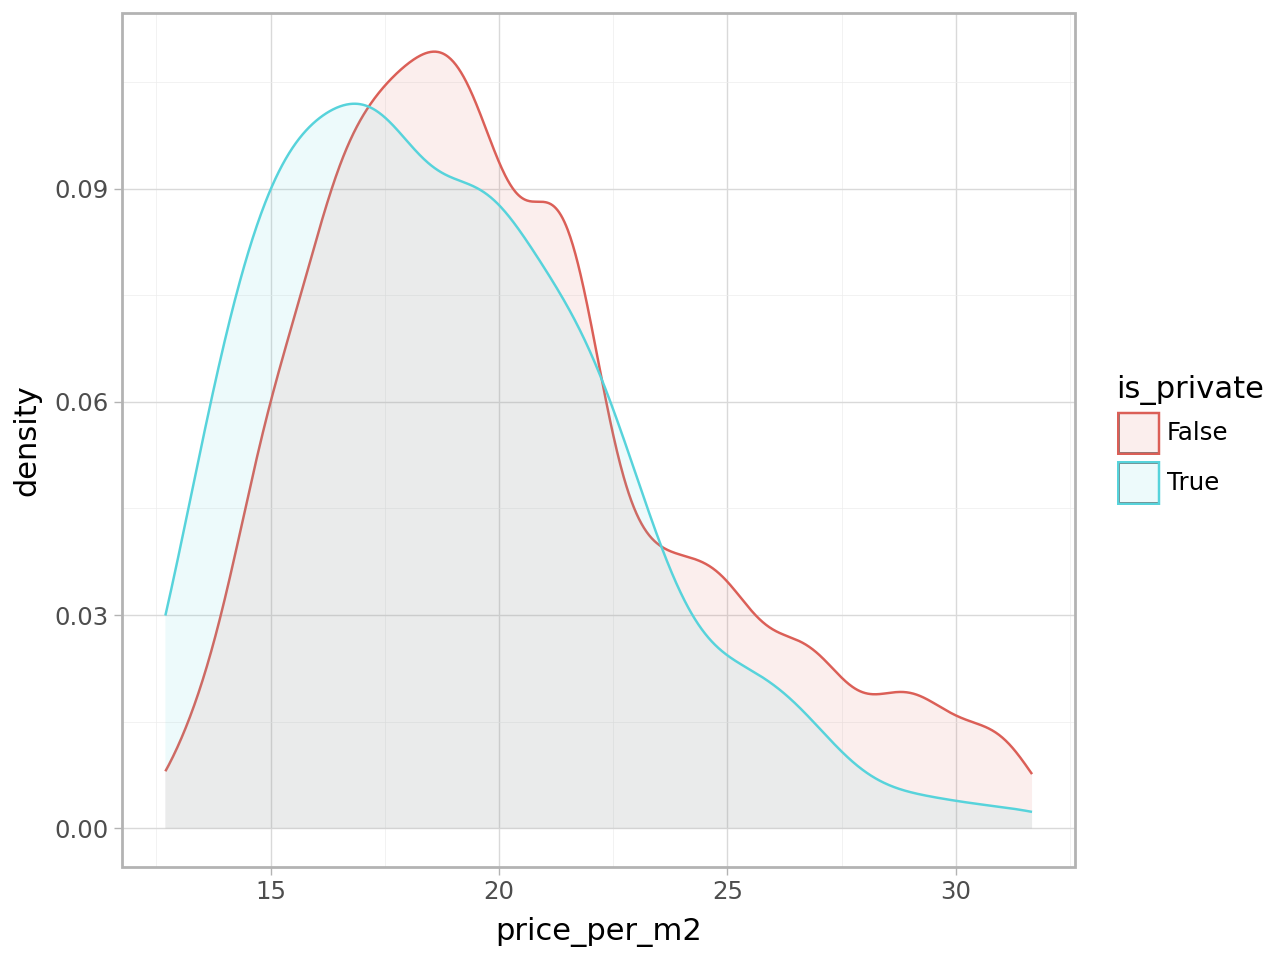

In [74]:
(
    ggplot(tiny_data)
    + aes(x = 'price_per_m2', color = 'is_private', fill = 'is_private')
    + geom_density(alpha = 0.1)
    + theme_light()
)

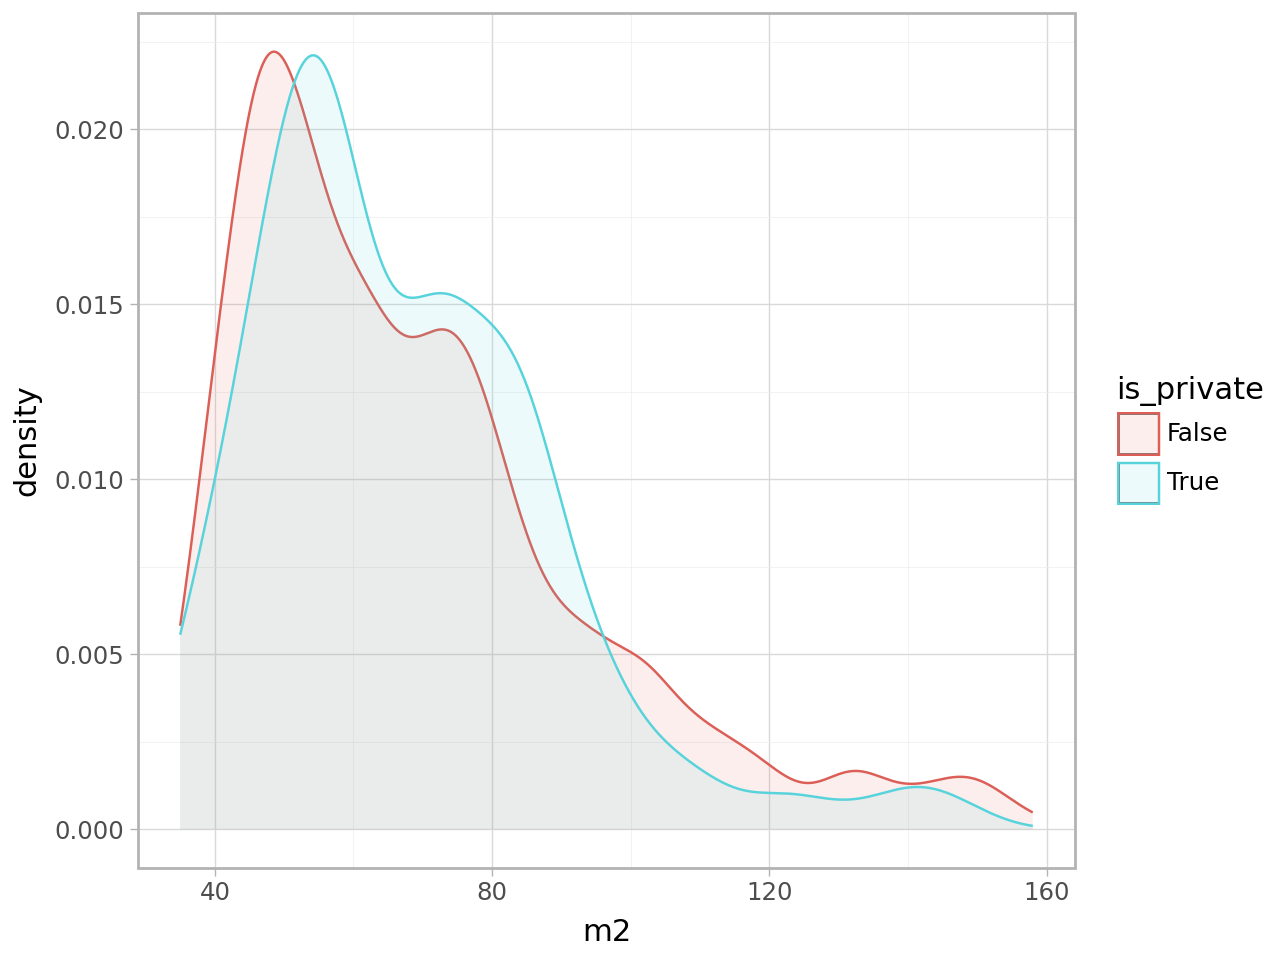

In [76]:
(
    ggplot(tiny_data)
    + aes(x = 'm2', color = 'is_private', fill = 'is_private')
    + geom_density(alpha = 0.1)
    + theme_light()
)

Lastly, let's compare values by whether the listing has some kind of terrace.

In [78]:
tiny_data['has_any_terrace'] = (
    tiny_data['has_balcony'] | 
    tiny_data['has_roof_terrace'] |
    tiny_data['has_garden'] |
    tiny_data['has_loggia'] |
    tiny_data['has_terrace'] |
    tiny_data['has_winter_garden']
)

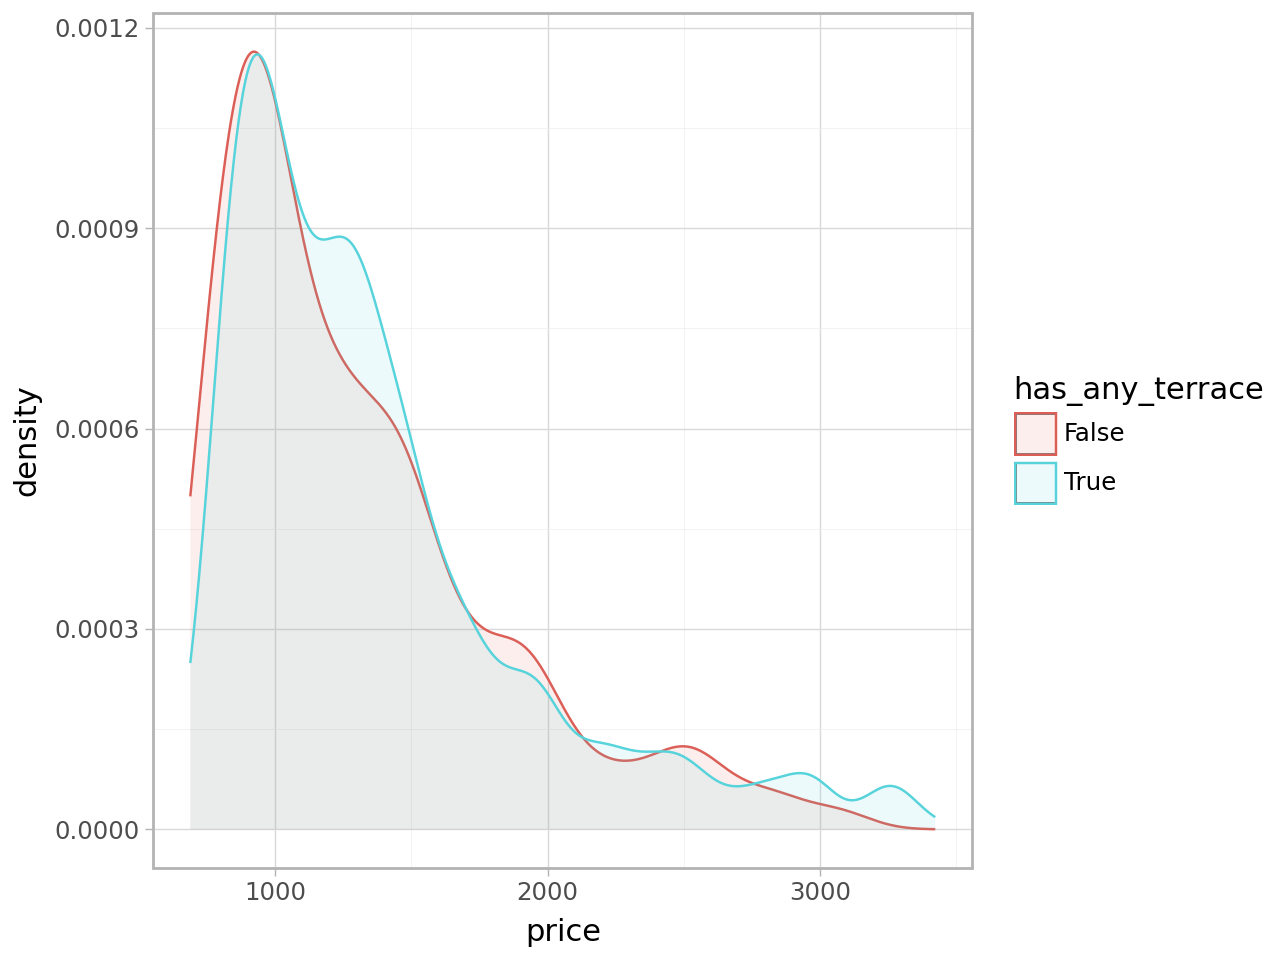

In [80]:
(
    ggplot(tiny_data)
    + aes(x = 'price', color = 'has_any_terrace', fill = 'has_any_terrace')
    + geom_density(alpha = 0.1)
    + theme_light()
)

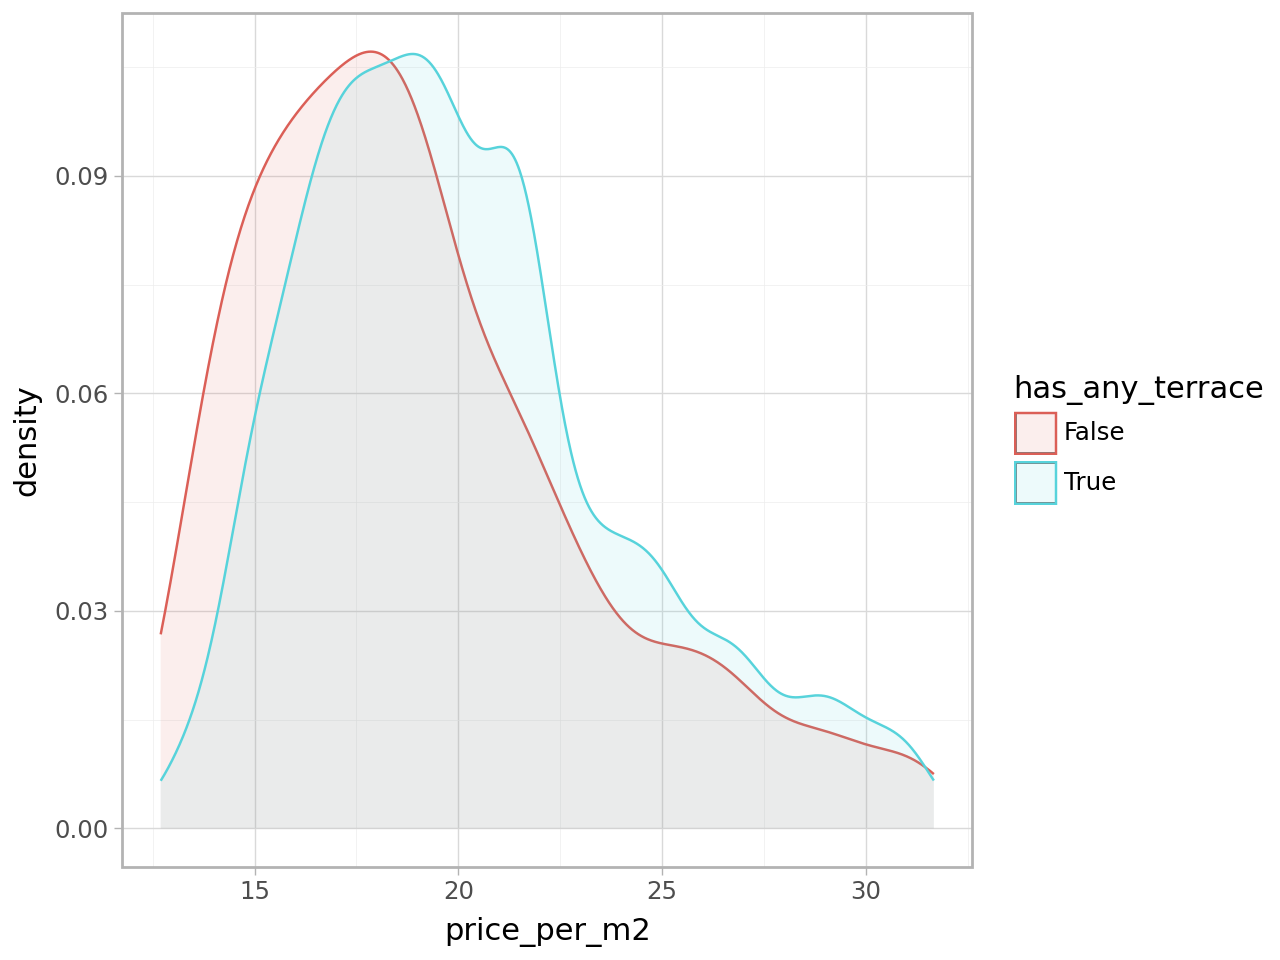

In [82]:
(
    ggplot(tiny_data)
    + aes(x = 'price_per_m2', color = 'has_any_terrace', fill = 'has_any_terrace')
    + geom_density(alpha = 0.1)
    + theme_light()
)

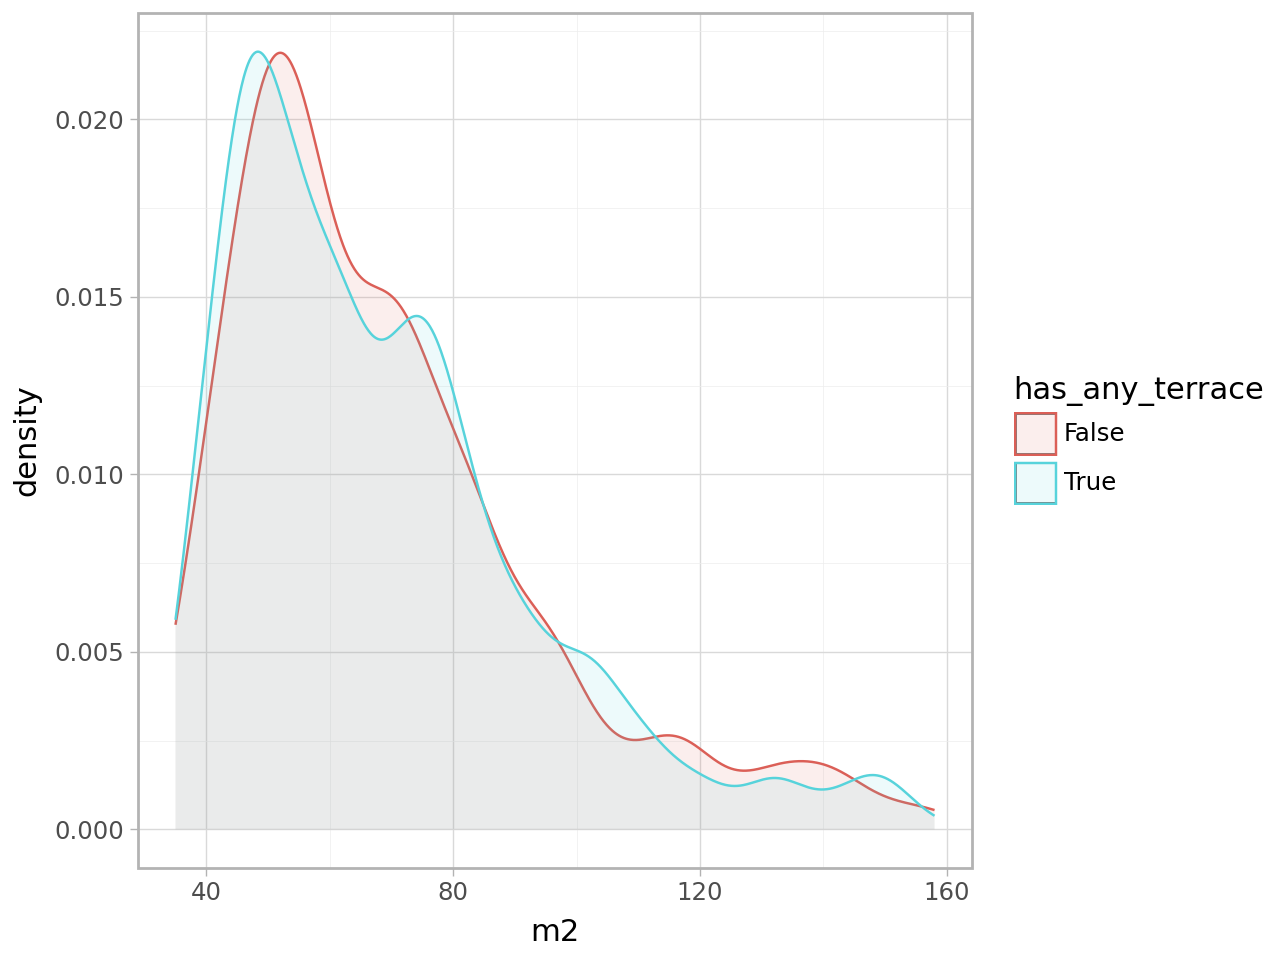

In [84]:
(
    ggplot(tiny_data)
    + aes(x = 'm2', color = 'has_any_terrace', fill = 'has_any_terrace')
    + geom_density(alpha = 0.1)
    + theme_light()
)

Now let's do some regression analysis! For that, I transform price, price per m2 and m2 by taking the logarithms to account for the right tails.

In [86]:
tiny_data['ln_price'] = np.log(tiny_data['price'])
tiny_data['ln_price_per_m2'] = np.log(tiny_data['price_per_m2'])
tiny_data['ln_m2'] = np.log(tiny_data['m2'])

To start, here are some non-parametric regressions using LOWESS.

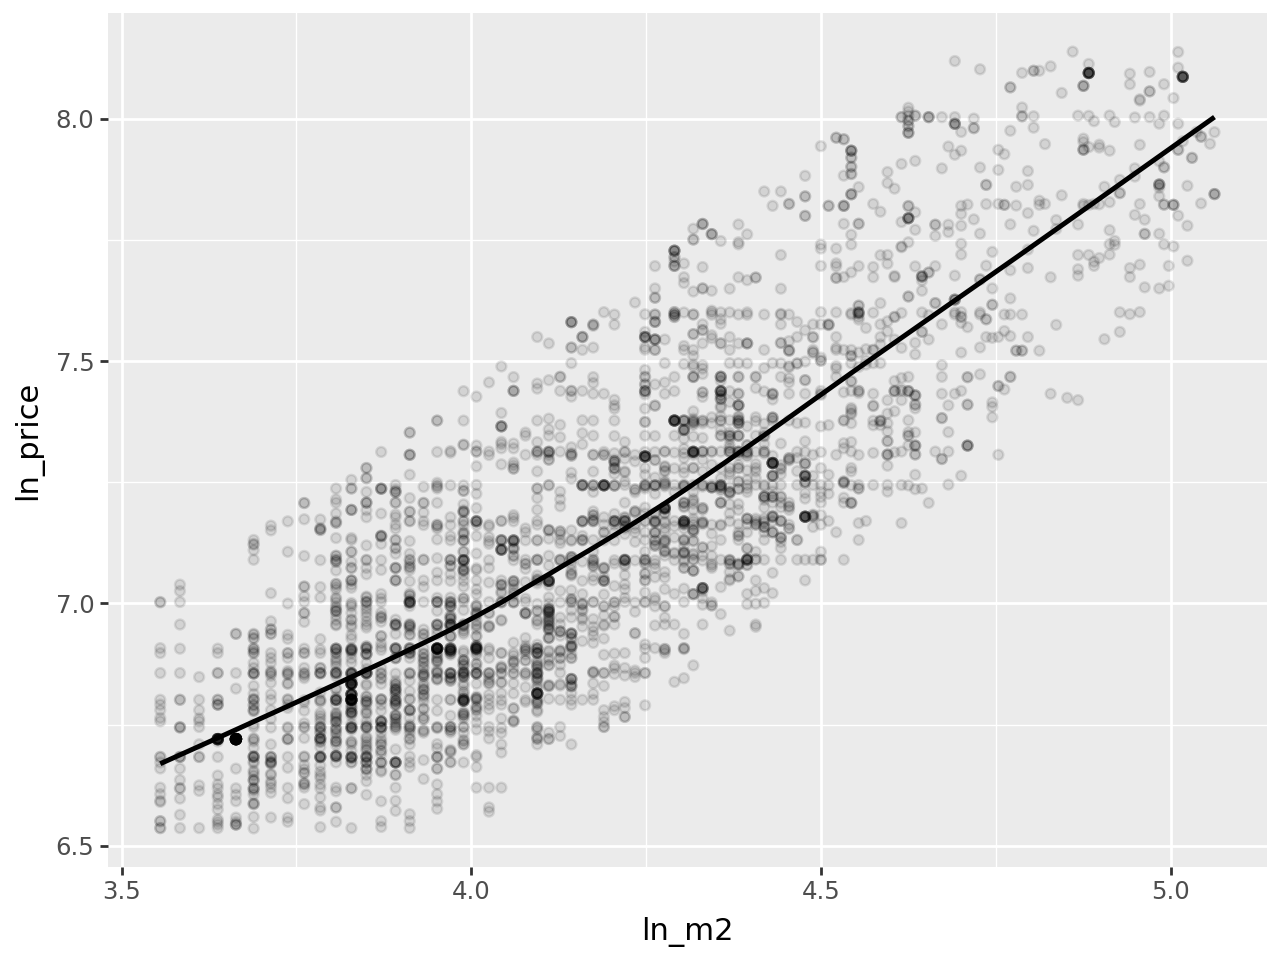

In [88]:
(
    ggplot(tiny_data)
    + aes(x = 'ln_m2', y = 'ln_price')
    + geom_point(alpha = 0.1)
    + geom_smooth(method = 'lowess')
)

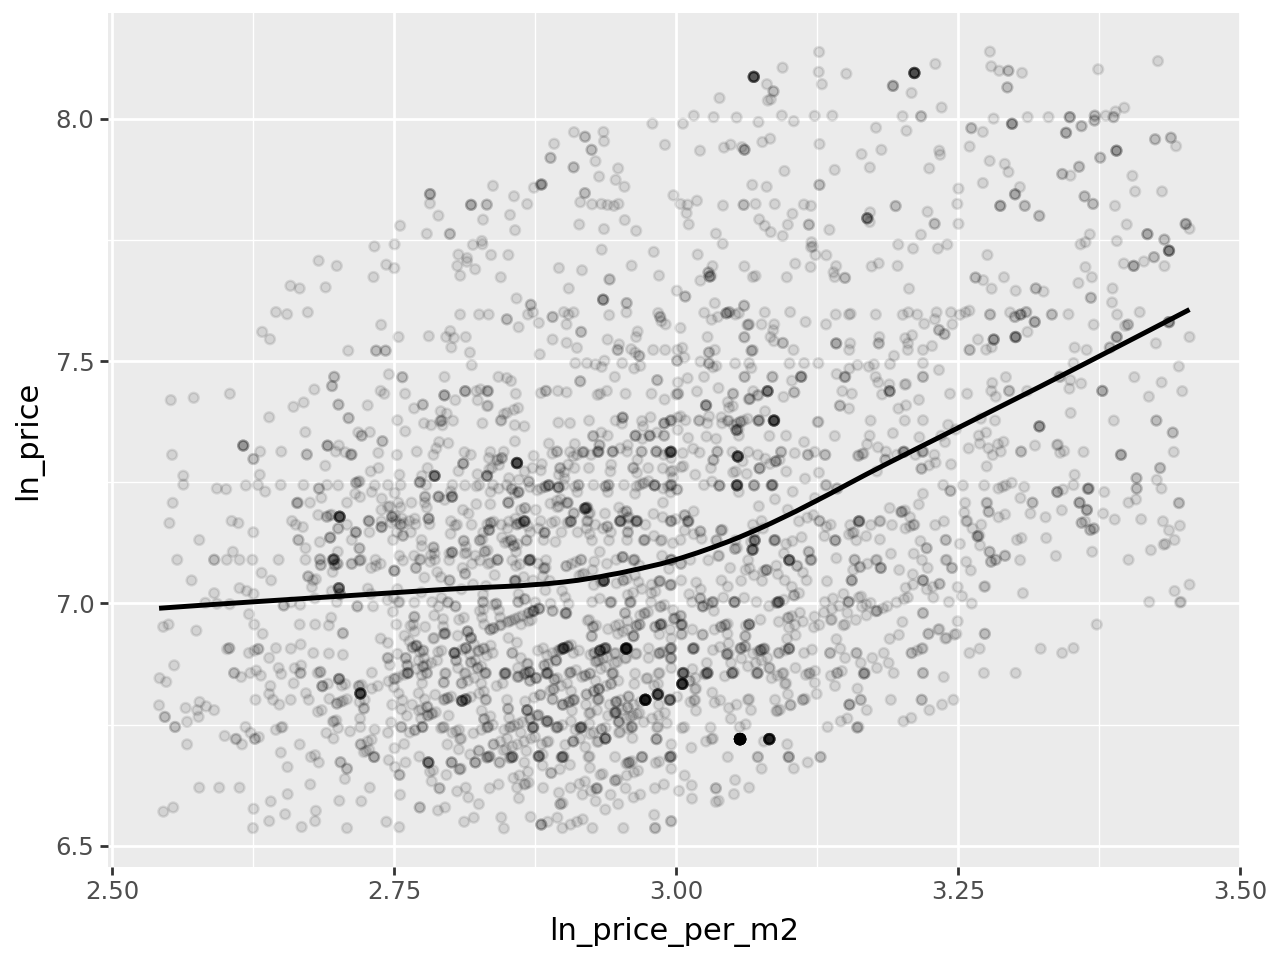

In [90]:
(
    ggplot(tiny_data)
    + aes(x = 'ln_price_per_m2', y = 'ln_price')
    + geom_point(alpha = 0.1)
    + geom_smooth(method = 'lowess')
)

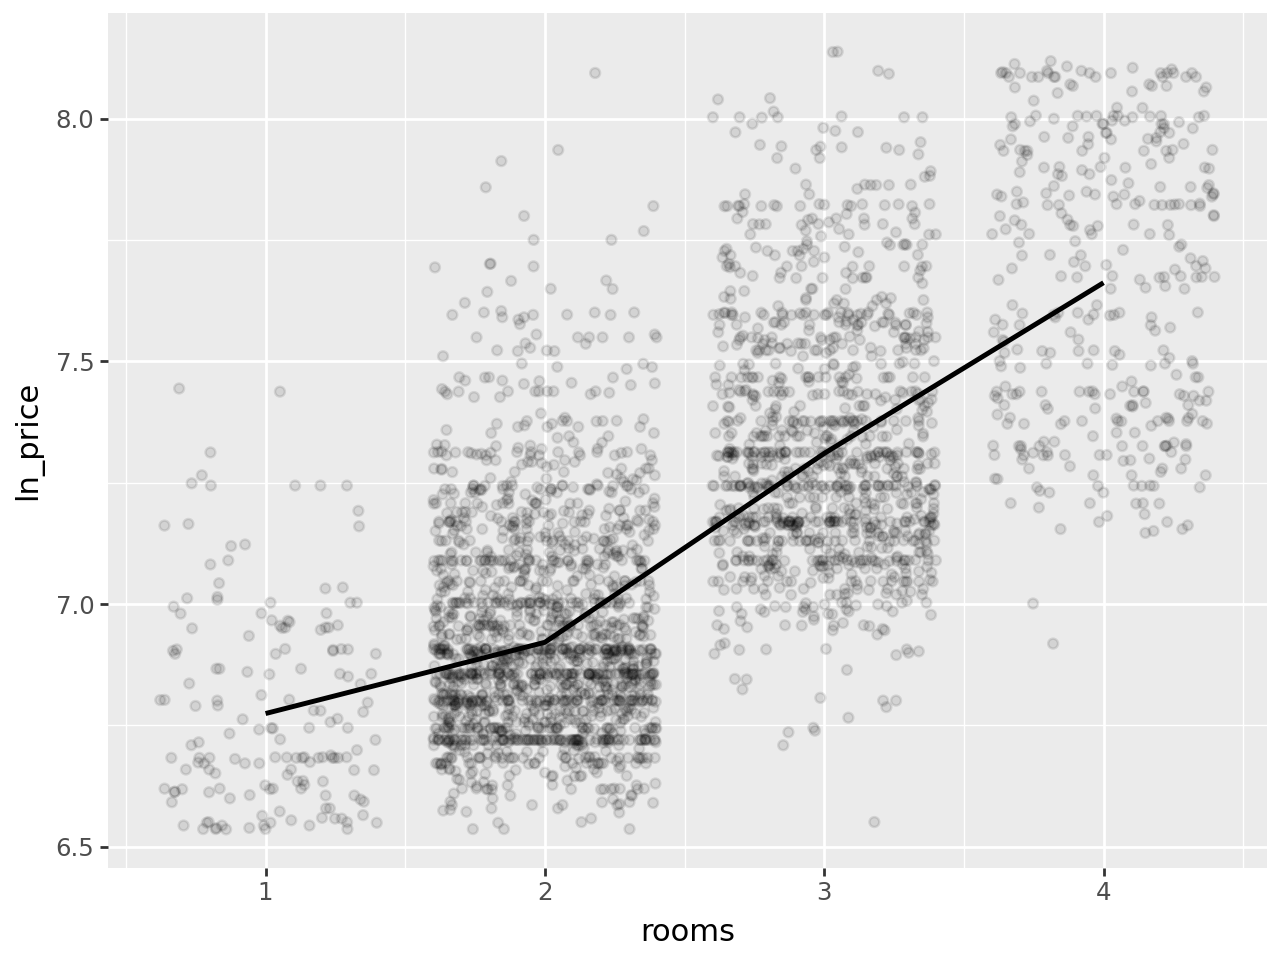

In [92]:
(
    ggplot(tiny_data)
    + aes(x = 'rooms', y = 'ln_price')
    + geom_jitter(alpha = 0.1)
    + geom_smooth(method = 'lowess')
)

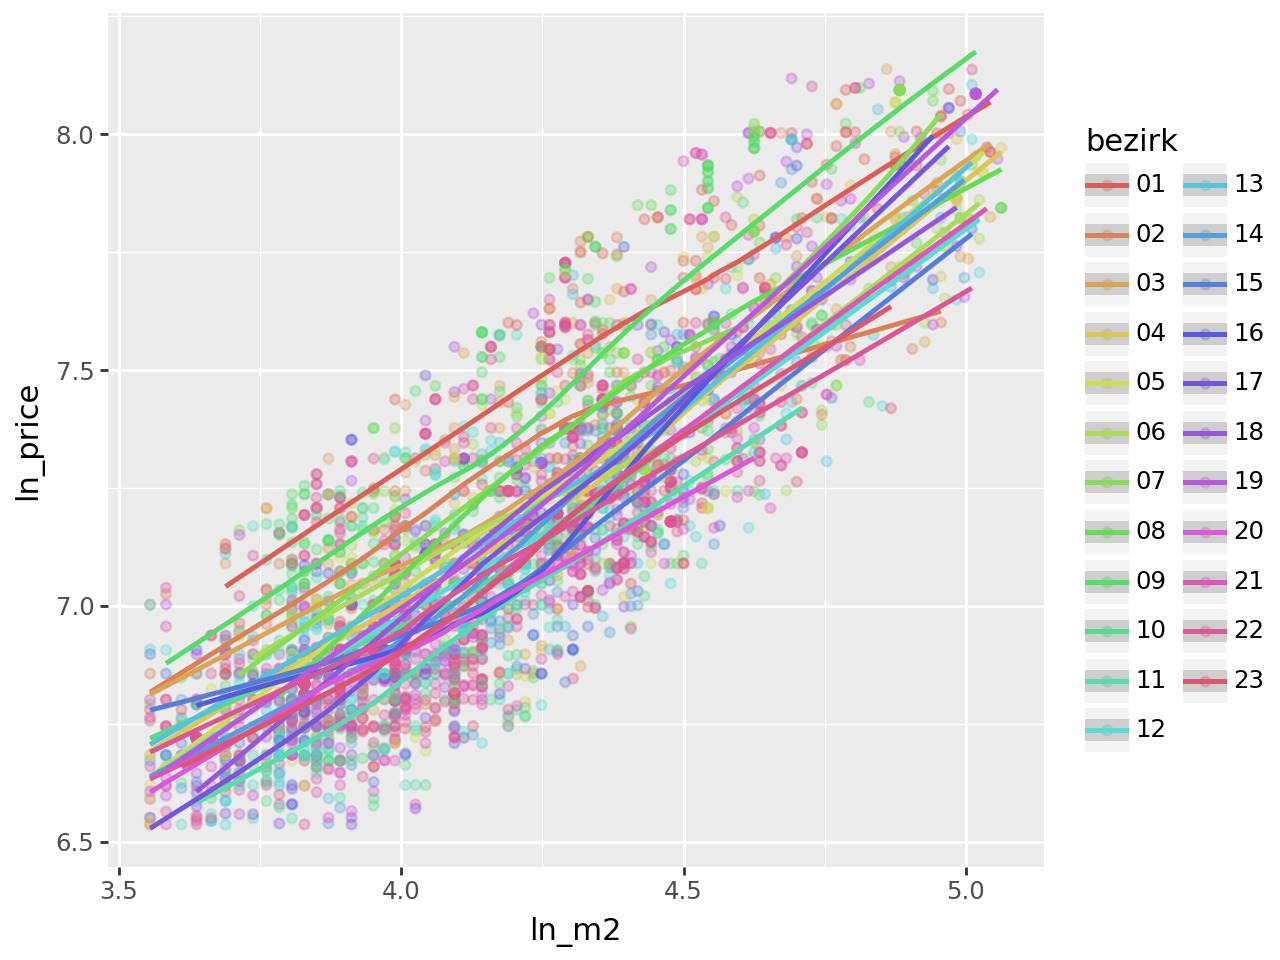

In [94]:
(
    ggplot(tiny_data)
    + aes(x = 'ln_m2', y = 'ln_price', color = 'bezirk')
    + geom_point(alpha = 0.3)
    + geom_smooth(method = 'lowess')
)

Finally, let's run a multiple regression using most of our variables!

In [96]:
reg_robust = smf.ols('ln_price~ln_m2+rooms+is_private+has_any_terrace+bezirk', data=tiny_data).fit(cov_type = 'HC3')
print(reg_robust.summary())
reg_m2 = smf.ols('ln_price~ln_m2', data=tiny_data).fit(cov_type = 'HC3')
print(reg_m2.summary())
reg_rooms = smf.ols('ln_price~rooms', data=tiny_data).fit(cov_type = 'HC3')
print(reg_rooms.summary())
reg_private = smf.ols('ln_price~is_private', data=tiny_data).fit(cov_type = 'HC3')
print(reg_private.summary())
reg_terrace = smf.ols('ln_price~has_any_terrace', data=tiny_data).fit(cov_type = 'HC3')
print(reg_terrace.summary())
reg_bezirk = smf.ols('ln_price~bezirk', data=tiny_data).fit(cov_type = 'HC3')
print(reg_bezirk.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     529.2
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:01:16   Log-Likelihood:                 1265.0
No. Observations:                3275   AIC:                            -2476.
Df Residuals:                    3248   BIC:                            -2311.
Df Model:                          26                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [98]:
table = Stargazer([reg_robust, reg_m2, reg_rooms, reg_private, reg_terrace, reg_bezirk])
table.covariate_order(['Intercept','ln_m2', 'rooms', 'has_any_terrace[T.True]', 'is_private[T.True]', 'bezirk[T.02]', 'bezirk[T.03]', 'bezirk[T.04]', 'bezirk[T.05]', 'bezirk[T.06]', 'bezirk[T.07]', 'bezirk[T.08]', 'bezirk[T.09]', 'bezirk[T.10]', 'bezirk[T.11]', 'bezirk[T.12]', 'bezirk[T.13]', 'bezirk[T.14]', 'bezirk[T.15]', 'bezirk[T.16]', 'bezirk[T.17]', 'bezirk[T.18]', 'bezirk[T.19]', 'bezirk[T.20]', 'bezirk[T.21]', 'bezirk[T.22]', 'bezirk[T.23]'])
table.add_custom_notes(["Robust standard errors used for all regressions."])

Let's also calculate separate regressions for each bezirk.

In [100]:
regs =  []
regs.append(smf.ols('ln_price~ln_m2+rooms+is_private+has_any_terrace', data=tiny_data).fit(cov_type = 'HC3'))
columns = ['all'] + [f'Bezirk{str(x)}' for x in range(1,24)]
for i in range(1,24):
    tiny_data_f = tiny_data[tiny_data['bezirk'].astype(int) == i]
    r = smf.ols('ln_price~ln_m2+rooms+is_private+has_any_terrace', data=tiny_data_f).fit(cov_type = 'HC3')
    regs.append(r)

In [102]:
table_bezirks = Stargazer(regs)
table_bezirks.custom_columns(columns)
table_bezirks.covariate_order(['Intercept','ln_m2', 'rooms', 'has_any_terrace[T.True]', 'is_private[T.True]'])
table_bezirks.add_custom_notes(["Robust standard errors used for all regressions."])

In [104]:
table

In [106]:
table_bezirks

From the above results in the two tables, we can draw some interesting conclusions:

- One average, a percent increase in the area of the flat goes together with a 0.6-0.8 percent increase in price.
- On average, an extra room in the flat is associated with a 6-8 percent increase in price.
- Having a terrace is an influential factor in the price of the flat (correlates with an average increase of 1-2 percent in price), but not in all bezirks.
- Similarly, private listings are cheaper on average (with around 1-5%), but this is not present in all of the bezirks.
- On average, similar flats are the most expensive in Bezirk 01, and the least expensive in Bezirk 11.